In [1]:
from Utils.DataPreprocessing import split_data, data_cleaning, glove_embedding
import torch
from torch import nn
from torch.utils.data import IterableDataset, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import GloVe, vocab, build_vocab_from_iterator
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import os

In [2]:
random_seed = 0
training_set_size = 0.8
GLOVE_TXT_PATH = '../../GloVe Embeddings/glove.840B.300d.txt'
MAX_TOKEN_NBS = 1500 # max number of tokens in each review

In [3]:
imdb_data = pd.read_csv('Data/IMDB Dataset.csv')
imdb_data = data_cleaning(imdb_data)
train_set, test_set = split_data(imdb_data, training_set_size, random_seed)

/mnt/i/Projects/evaluation-deeplearning-NLP/Utils/DataPreprocessing.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['review'] = dataset['review'].str.replace('<.*?>', '')


In [4]:
train_set.describe()

sentiment
count  40000.000000
mean       0.500875
std        0.500005
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000

In [5]:
test_set.describe()

sentiment
count  10000.000000
mean       0.496500
std        0.500013
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

In [6]:
if os.path.isdir("./.vector_cache"):
    glove_vectors = GloVe(name = '840B', cache = './.vector_cache')
else:
    glove_vectors = GloVe('840B')

In [7]:
glove_vectors

In [8]:
pad_token = "<pad>"
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<pad>", 0)
# This is necessary otherwise it will throw runtime error if OOV token is queried
glove_vocab.set_default_index(0)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))

In [9]:
tokenizer = get_tokenizer("basic_english")

class MyDataset(Dataset):
    def __init__(self, dataframe, max_len=1500, pad_token='<pad>'):
         self.X = dataframe['review'].values
         self.Y = dataframe['sentiment'].to_numpy()
         self.max_len = max_len
         self.pad_token = pad_token

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        t = idx
        tokens = tokenizer(self.X[t])[:self.max_len]
        diff = self.max_len - len(tokens)
        if diff > 0:
            tokens =  tokens + [self.pad_token] * diff
        indices = glove_vocab(tokens)
        result = {
            'text': tokens,
            'indices': torch.tensor(indices),
            'labels': torch.tensor(self.Y[t], dtype=torch.float)
        }
        return result

In [10]:
train_dataset = MyDataset(train_set, MAX_TOKEN_NBS)
test_dataset = MyDataset(test_set, MAX_TOKEN_NBS)

In [11]:
for idx, data in enumerate(train_dataset):
    print("---------------------------------")
    print('next example id ', idx)
    example_text = data['text']
    print(example_text)
    print(data['labels'])
    break


---------------------------------
next example id  0
['that', 'is', 'about', 'the', 'only', 'redeeming', 'quality', 'in', 'a', 'movie', 'that', 'otherwise', 'insults', 'the', 'viewer', "'", 's', 'intelligence', 'by', 'losing', 'track', 'of', 'time', ',', 'plot', ',', 'and', 'reason', 'for', 'being', 'produced', '.', 'plus', ',', 'how', 'that', 'guy', 'with', 'the', 'glasses', 'ever', 'got', 'a', 'gig', 'in', 'hollywood', 'is', 'beyond', 'me', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

In [12]:
class TextClassificationModel(nn.Module):
    def __init__(self, pretrained_embeddings, num_class, hidden_size, freeze_embeddings = True):
        super(TextClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=False)
        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], hidden_size, num_layers=2, bidirectional=True, dropout=0.5)
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, num_class)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        self.LN = nn.LayerNorm(hidden_size * 4)

    def forward(self, indices):

        embedded = self.embedding(indices.T)
        self.lstm.flatten_parameters()
        lstm_out, _ = self.lstm(embedded)
        encoding = torch.cat((lstm_out[0], lstm_out[-1]), dim=1)

        out = self.LN(encoding)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

Epoch: 0 Train_Loss: 0.6945696671169025 Train_Accuracy: 0.50195
Epoch: 0 Test_Loss: 0.6838953909994681 Test_Accuracy: 0.5065


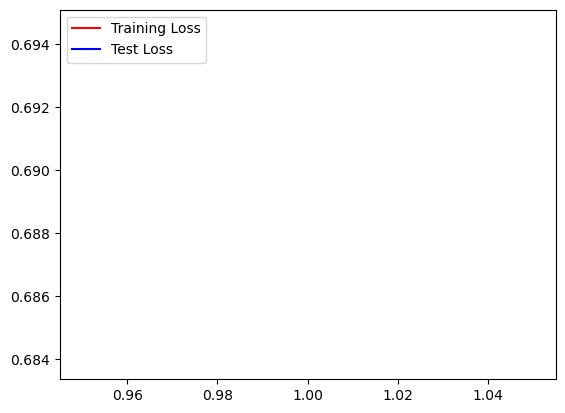

Epoch: 1 Train_Loss: 0.6874738889761245 Train_Accuracy: 0.508975
Epoch: 1 Test_Loss: 0.6787374464771415 Test_Accuracy: 0.5159


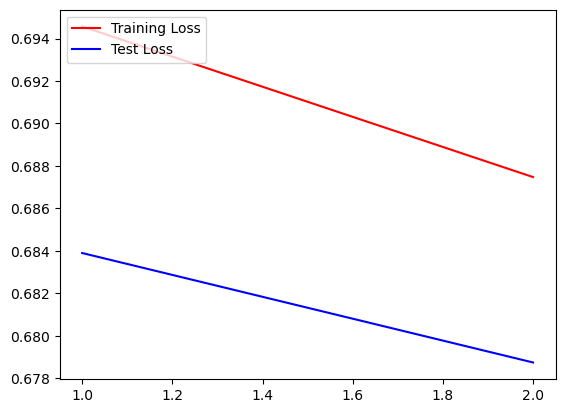

Epoch: 2 Train_Loss: 0.6805348118273215 Train_Accuracy: 0.51975
Epoch: 2 Test_Loss: 0.6734092024308217 Test_Accuracy: 0.5291


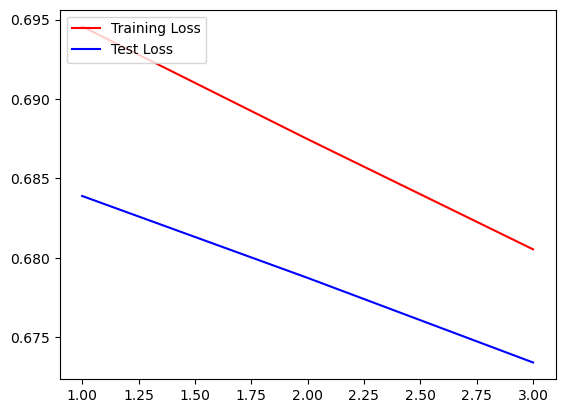

Epoch: 3 Train_Loss: 0.6758447306605574 Train_Accuracy: 0.53625
Epoch: 3 Test_Loss: 0.6693245270584203 Test_Accuracy: 0.552


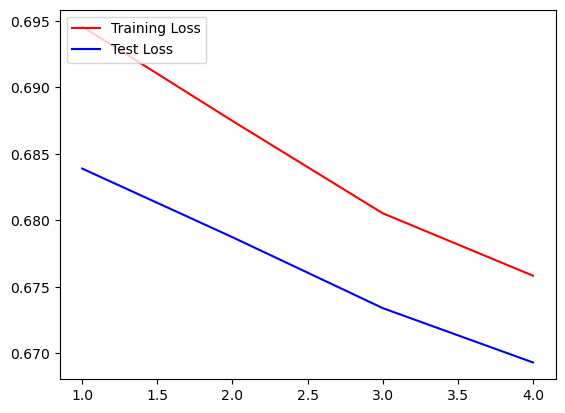

Epoch: 4 Train_Loss: 0.6686378824063384 Train_Accuracy: 0.546875
Epoch: 4 Test_Loss: 0.6635863592353048 Test_Accuracy: 0.5707


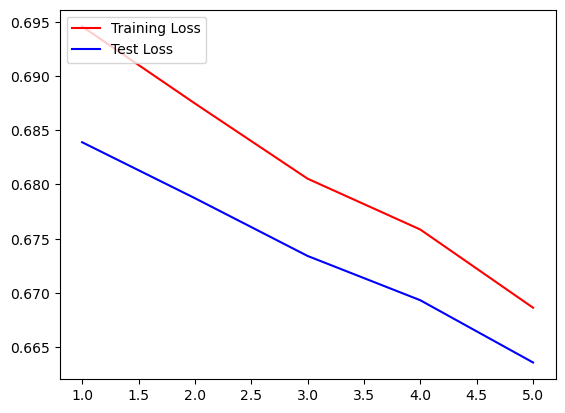

Epoch: 5 Train_Loss: 0.6619897244837337 Train_Accuracy: 0.5609
Epoch: 5 Test_Loss: 0.6569150769257848 Test_Accuracy: 0.5607


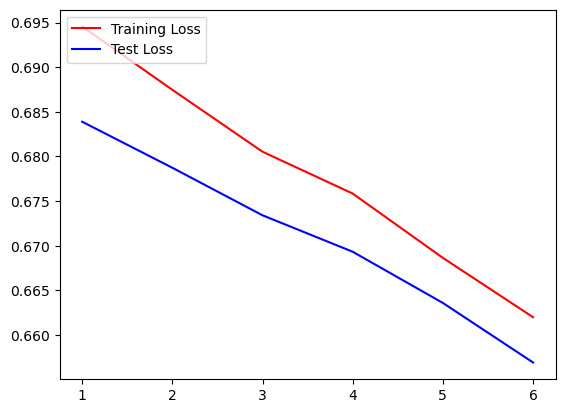

Epoch: 6 Train_Loss: 0.6539912743690296 Train_Accuracy: 0.57365
Epoch: 6 Test_Loss: 0.6481499581397334 Test_Accuracy: 0.5929


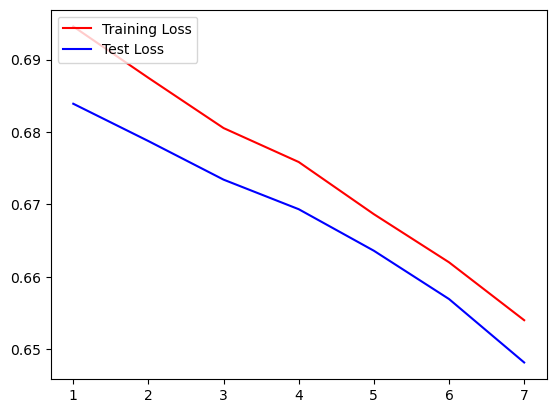

Epoch: 7 Train_Loss: 0.64474397535903 Train_Accuracy: 0.591525
Epoch: 7 Test_Loss: 0.6411050791981854 Test_Accuracy: 0.6159


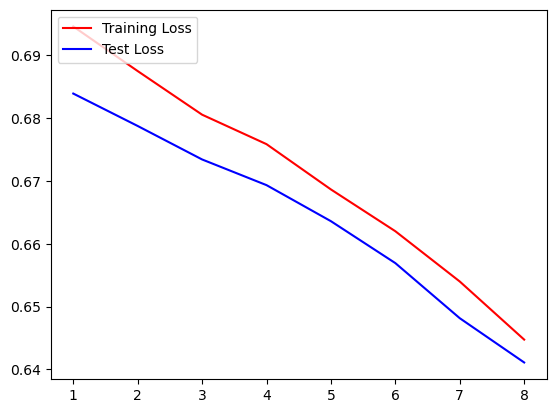

Epoch: 8 Train_Loss: 0.6322362893305647 Train_Accuracy: 0.60975
Epoch: 8 Test_Loss: 0.6244601079180271 Test_Accuracy: 0.6512


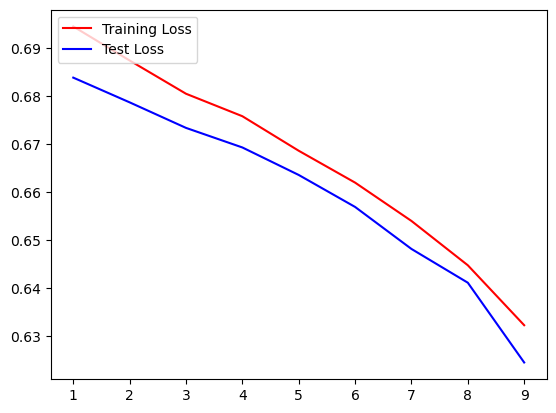

Epoch: 9 Train_Loss: 0.5941906738014647 Train_Accuracy: 0.6677
Epoch: 9 Test_Loss: 0.5699339188352416 Test_Accuracy: 0.7098


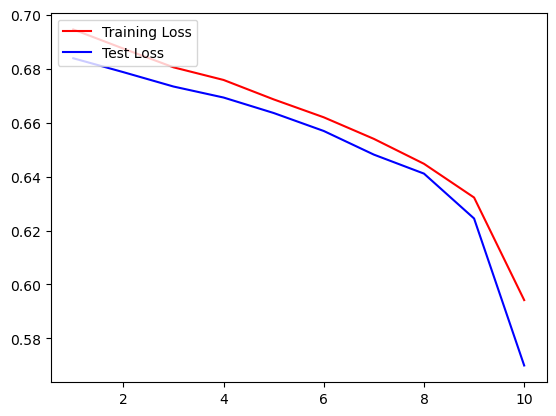

Epoch: 10 Train_Loss: 0.5673762815067181 Train_Accuracy: 0.702925
Epoch: 10 Test_Loss: 0.5872730156288871 Test_Accuracy: 0.7045


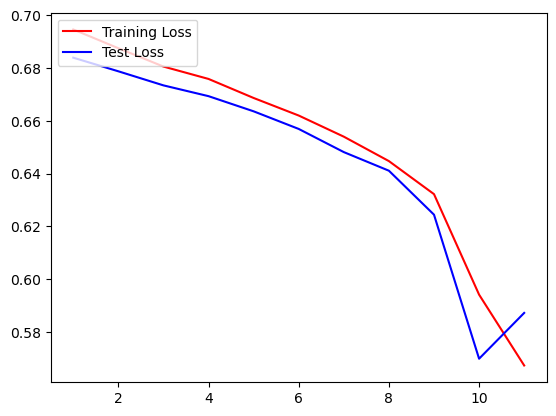

Epoch: 11 Train_Loss: 0.5528141767643511 Train_Accuracy: 0.7163
Epoch: 11 Test_Loss: 0.5392465089695363 Test_Accuracy: 0.7363


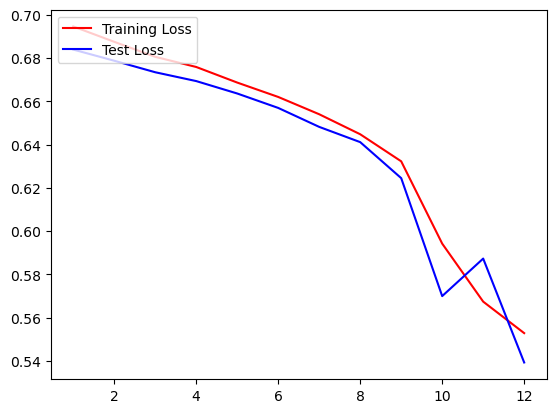

Epoch: 12 Train_Loss: 0.5400675601852588 Train_Accuracy: 0.7293
Epoch: 12 Test_Loss: 0.5339950692804554 Test_Accuracy: 0.743


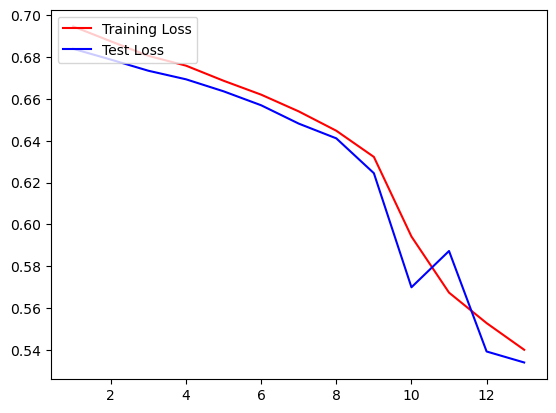

Epoch: 13 Train_Loss: 0.5293035227269791 Train_Accuracy: 0.73625
Epoch: 13 Test_Loss: 0.5221806142149092 Test_Accuracy: 0.747


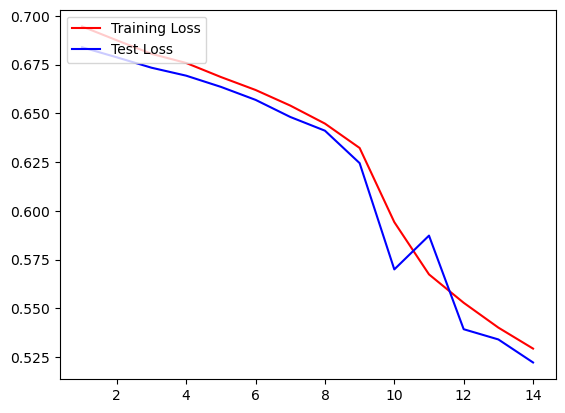

Epoch: 14 Train_Loss: 0.5242336493330642 Train_Accuracy: 0.7426
Epoch: 14 Test_Loss: 0.5090316718892206 Test_Accuracy: 0.763


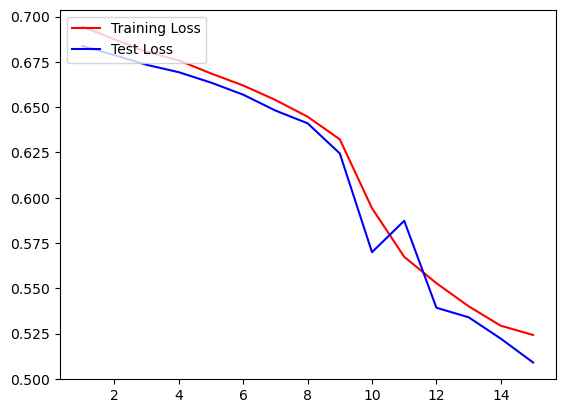

Epoch: 15 Train_Loss: 0.5137364453020187 Train_Accuracy: 0.74955
Epoch: 15 Test_Loss: 0.5208472017245956 Test_Accuracy: 0.7634


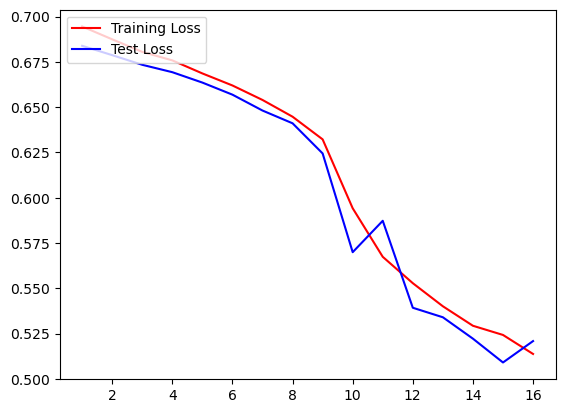

Epoch: 16 Train_Loss: 0.5040291831516229 Train_Accuracy: 0.7582
Epoch: 16 Test_Loss: 0.5016770098782792 Test_Accuracy: 0.7726


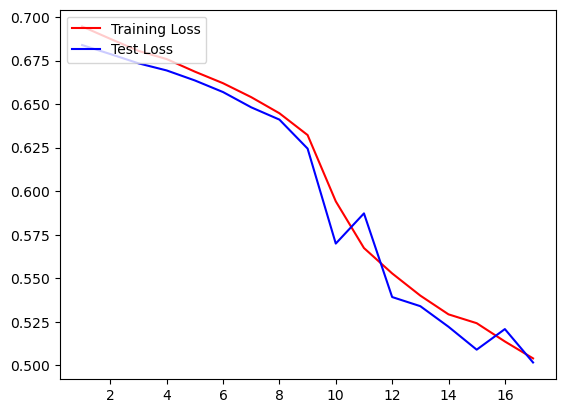

Epoch: 17 Train_Loss: 0.49613574994638704 Train_Accuracy: 0.7622
Epoch: 17 Test_Loss: 0.492017347224151 Test_Accuracy: 0.7703


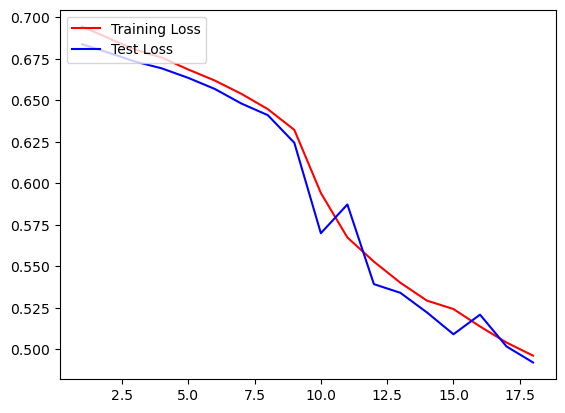

Epoch: 18 Train_Loss: 0.49275417516406733 Train_Accuracy: 0.765
Epoch: 18 Test_Loss: 0.4918357284763191 Test_Accuracy: 0.7795


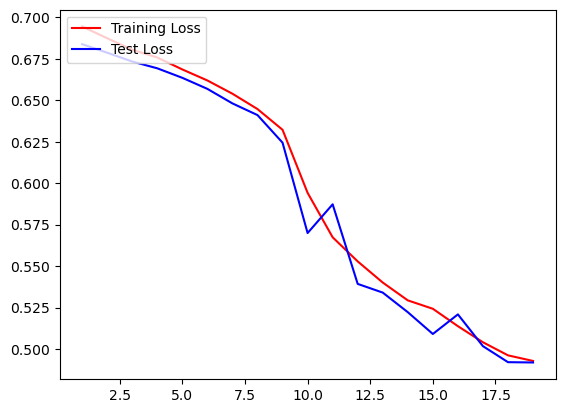

Epoch: 19 Train_Loss: 0.4834177990119678 Train_Accuracy: 0.772125
Epoch: 19 Test_Loss: 0.47102523000934454 Test_Accuracy: 0.7857


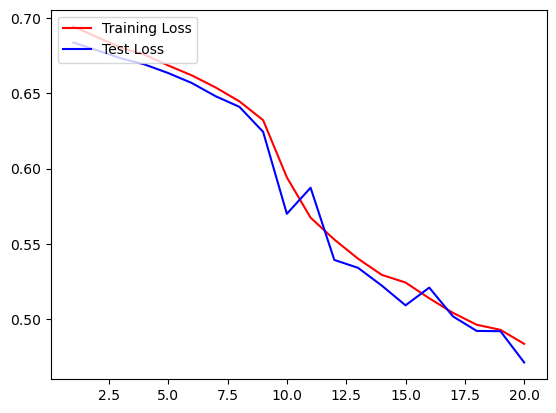

Epoch: 20 Train_Loss: 0.4784176385821626 Train_Accuracy: 0.77435
Epoch: 20 Test_Loss: 0.5016043295588675 Test_Accuracy: 0.7806


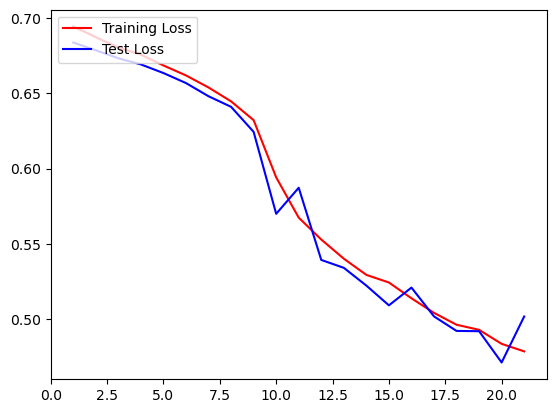

Epoch: 21 Train_Loss: 0.46849383389987886 Train_Accuracy: 0.780125
Epoch: 21 Test_Loss: 0.46031446434274503 Test_Accuracy: 0.7961


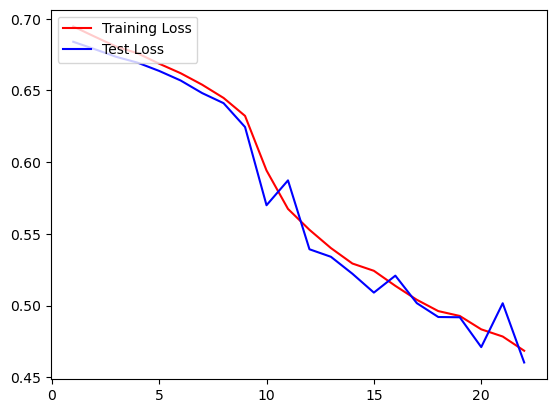

Epoch: 22 Train_Loss: 0.4618944423838545 Train_Accuracy: 0.783475
Epoch: 22 Test_Loss: 0.4485147614267808 Test_Accuracy: 0.7951


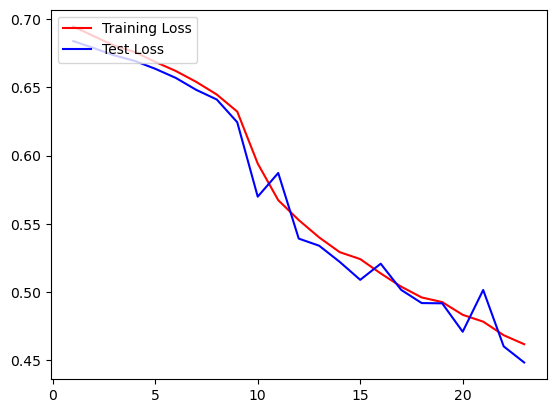

Epoch: 23 Train_Loss: 0.4548759762281046 Train_Accuracy: 0.7888
Epoch: 23 Test_Loss: 0.4561087873917592 Test_Accuracy: 0.8016


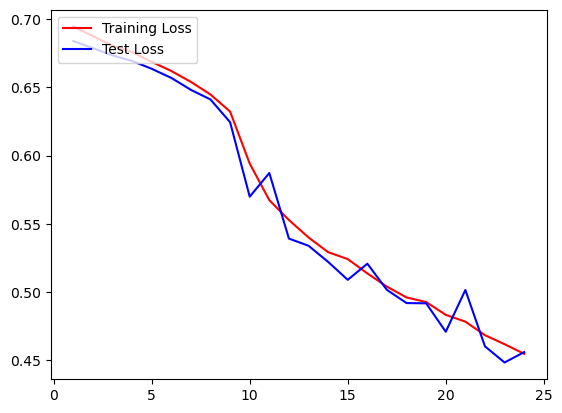

Epoch: 24 Train_Loss: 0.44455581246473536 Train_Accuracy: 0.791775
Epoch: 24 Test_Loss: 0.480156655553021 Test_Accuracy: 0.7642


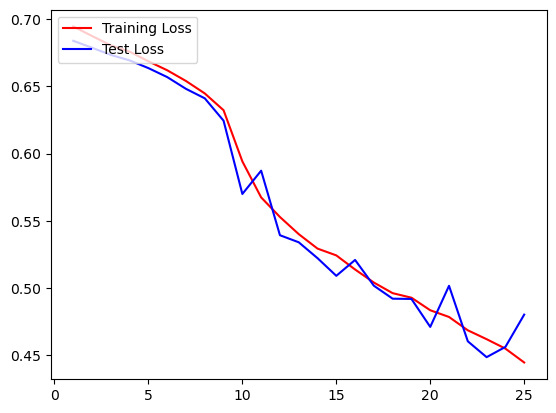

Epoch: 25 Train_Loss: 0.43866768717384946 Train_Accuracy: 0.794425
Epoch: 25 Test_Loss: 0.4511711506903926 Test_Accuracy: 0.8108


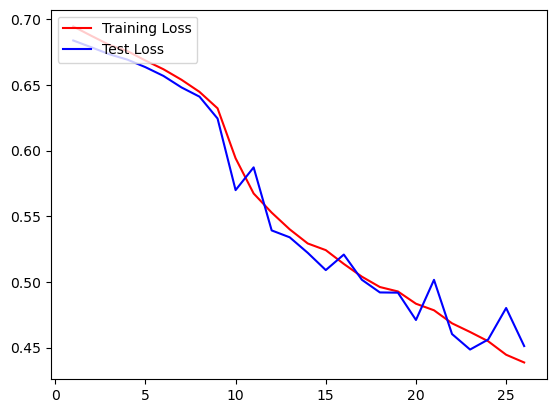

Epoch: 26 Train_Loss: 0.436549338003317 Train_Accuracy: 0.796
Epoch: 26 Test_Loss: 0.431357659116576 Test_Accuracy: 0.8104


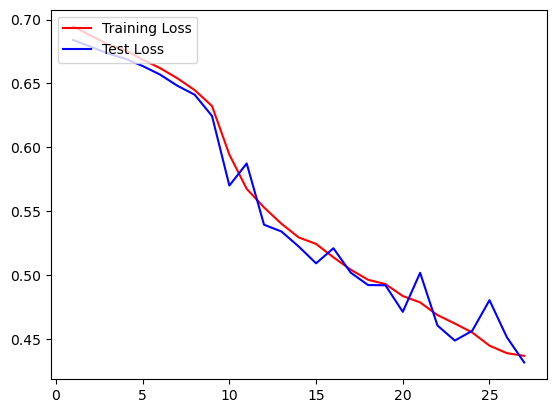

Epoch: 27 Train_Loss: 0.4275395664544151 Train_Accuracy: 0.80145
Epoch: 27 Test_Loss: 0.4423049080975448 Test_Accuracy: 0.8113


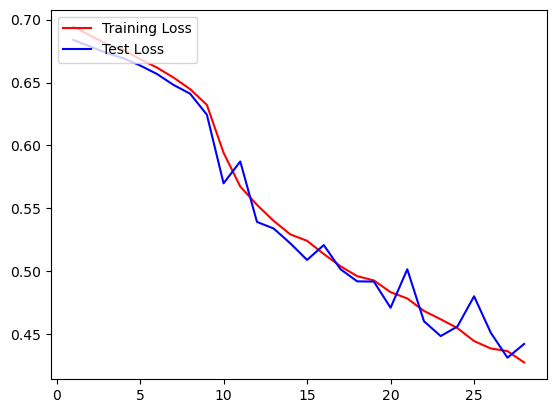

Epoch: 28 Train_Loss: 0.4205402609067984 Train_Accuracy: 0.804975
Epoch: 28 Test_Loss: 0.45493671712996087 Test_Accuracy: 0.8084


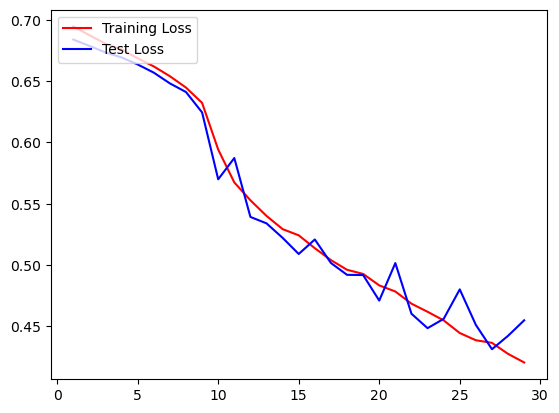

Epoch: 29 Train_Loss: 0.41573810215575246 Train_Accuracy: 0.808725
Epoch: 29 Test_Loss: 0.4187715460982504 Test_Accuracy: 0.8178


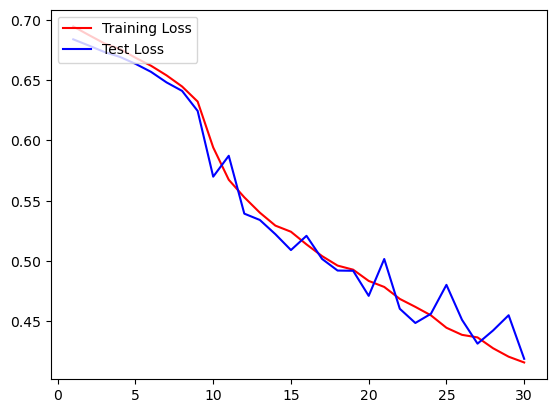

Epoch: 30 Train_Loss: 0.41421084653455226 Train_Accuracy: 0.809025
Epoch: 30 Test_Loss: 0.4198120025139821 Test_Accuracy: 0.8229


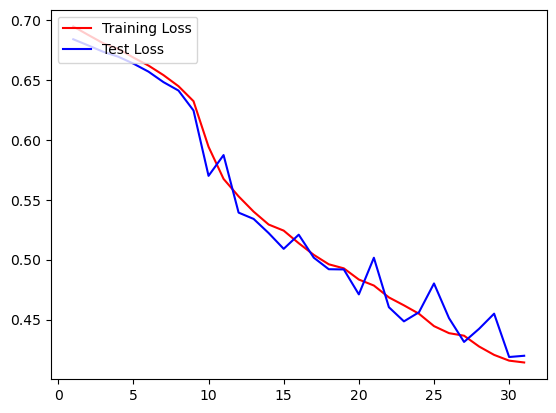

Epoch: 31 Train_Loss: 0.4059256046724776 Train_Accuracy: 0.813675
Epoch: 31 Test_Loss: 0.4071380828000322 Test_Accuracy: 0.8221


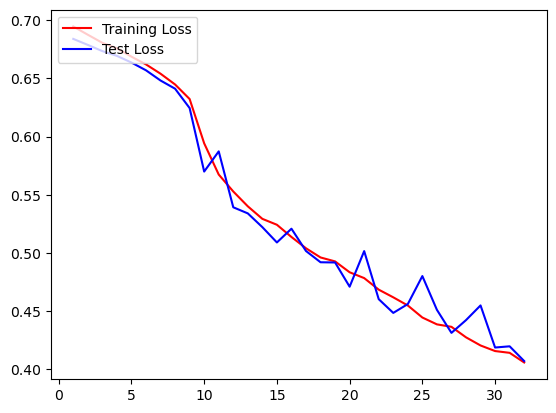

Epoch: 32 Train_Loss: 0.40170963646504826 Train_Accuracy: 0.816075
Epoch: 32 Test_Loss: 0.4134069220929206 Test_Accuracy: 0.8209


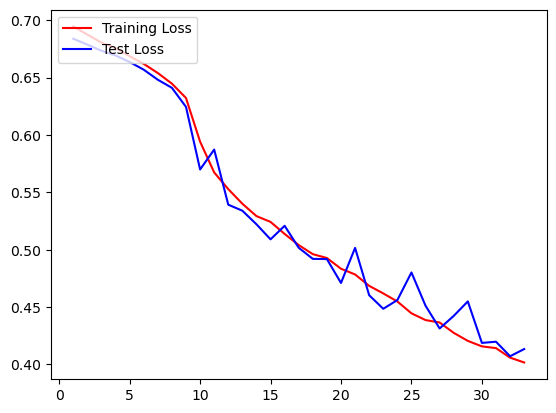

Epoch: 33 Train_Loss: 0.39883680617847383 Train_Accuracy: 0.818725
Epoch: 33 Test_Loss: 0.42940795044355756 Test_Accuracy: 0.8286


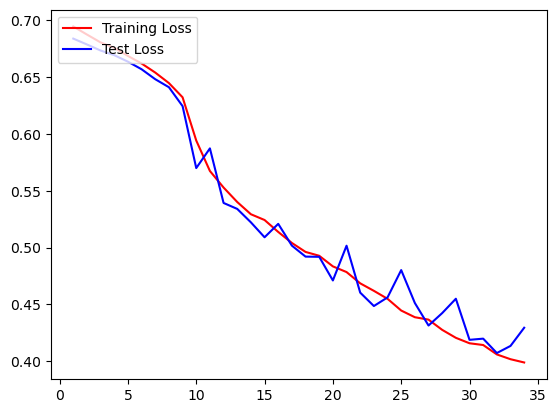

Epoch: 34 Train_Loss: 0.38893639570036637 Train_Accuracy: 0.823975
Epoch: 34 Test_Loss: 0.4700089742111254 Test_Accuracy: 0.8176


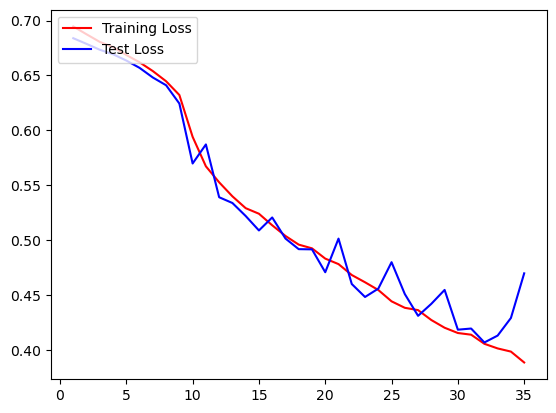

Epoch: 35 Train_Loss: 0.385947765205234 Train_Accuracy: 0.826375
Epoch: 35 Test_Loss: 0.40702803112283537 Test_Accuracy: 0.8317


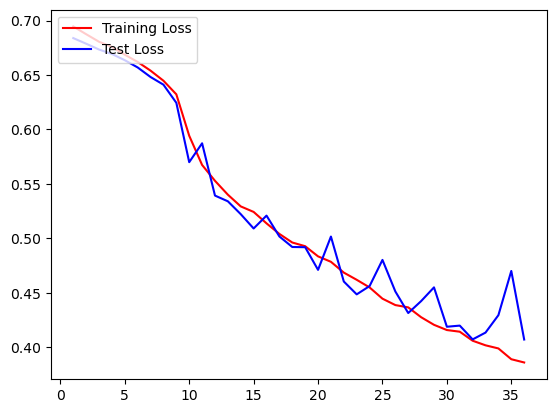

Epoch: 36 Train_Loss: 0.3779705146345468 Train_Accuracy: 0.83035
Epoch: 36 Test_Loss: 0.42784768833389764 Test_Accuracy: 0.8298


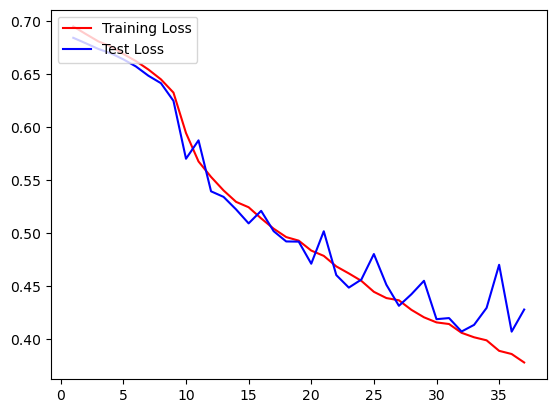

Epoch: 37 Train_Loss: 0.37735687791349026 Train_Accuracy: 0.83165
Epoch: 37 Test_Loss: 0.40109513417074955 Test_Accuracy: 0.831


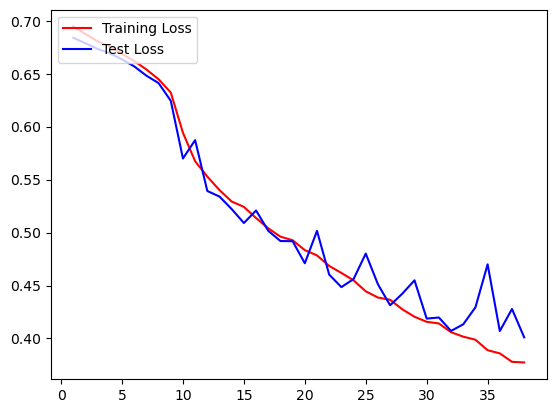

Epoch: 38 Train_Loss: 0.37115112351723756 Train_Accuracy: 0.836375
Epoch: 38 Test_Loss: 0.3887349472770208 Test_Accuracy: 0.84


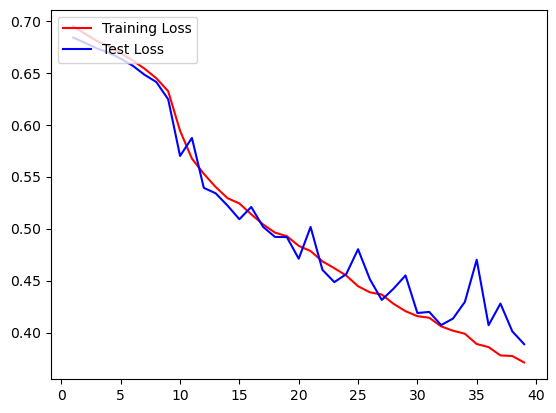

Epoch: 39 Train_Loss: 0.3678344265340616 Train_Accuracy: 0.837
Epoch: 39 Test_Loss: 0.40336048074915437 Test_Accuracy: 0.8403


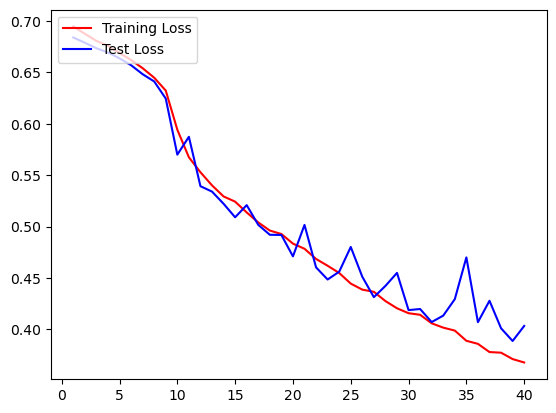

Epoch: 40 Train_Loss: 0.3654789996508973 Train_Accuracy: 0.837675
Epoch: 40 Test_Loss: 0.39816483553451826 Test_Accuracy: 0.8223


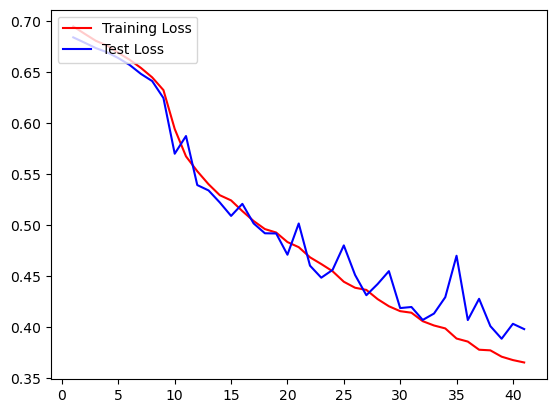

Epoch: 41 Train_Loss: 0.3595622482295996 Train_Accuracy: 0.840375
Epoch: 41 Test_Loss: 0.40778872898862334 Test_Accuracy: 0.8257


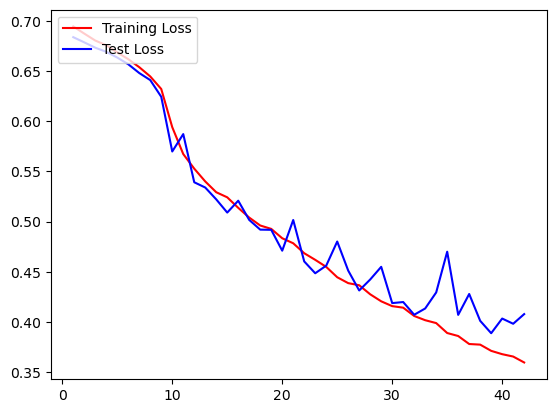

Epoch: 42 Train_Loss: 0.35730515548977226 Train_Accuracy: 0.84095
Epoch: 42 Test_Loss: 0.4555738496629498 Test_Accuracy: 0.8127


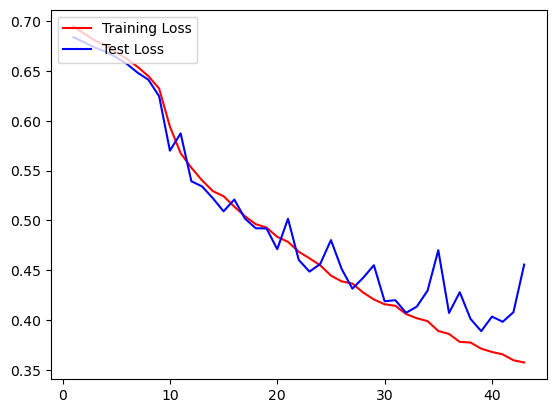

Epoch: 43 Train_Loss: 0.3500304711036408 Train_Accuracy: 0.845925
Epoch: 43 Test_Loss: 0.39448409197451195 Test_Accuracy: 0.8466


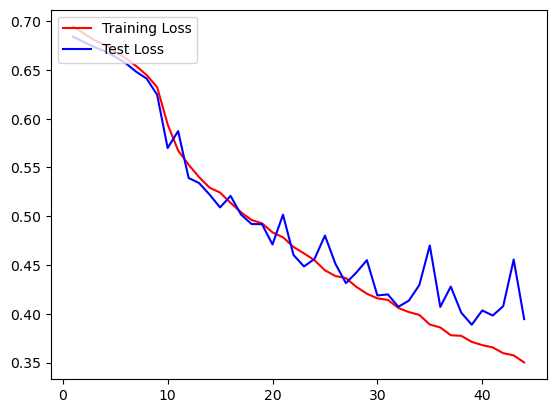

Epoch: 44 Train_Loss: 0.35059240850777673 Train_Accuracy: 0.846225
Epoch: 44 Test_Loss: 0.3855092314225209 Test_Accuracy: 0.8501


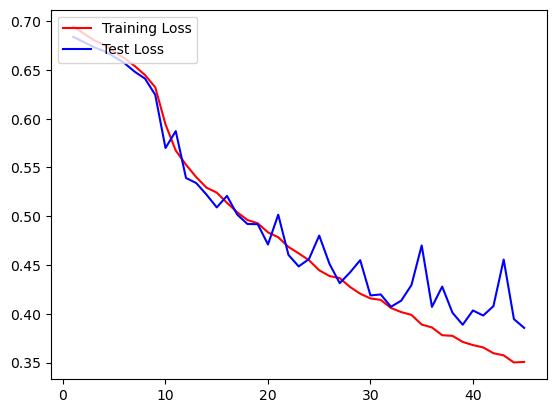

Epoch: 45 Train_Loss: 0.34306271678913897 Train_Accuracy: 0.8501
Epoch: 45 Test_Loss: 0.36835714929466007 Test_Accuracy: 0.8515


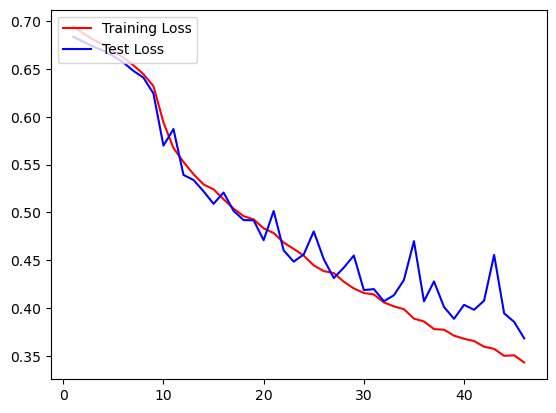

Epoch: 46 Train_Loss: 0.3412052946159253 Train_Accuracy: 0.851525
Epoch: 46 Test_Loss: 0.3722421949422812 Test_Accuracy: 0.8364


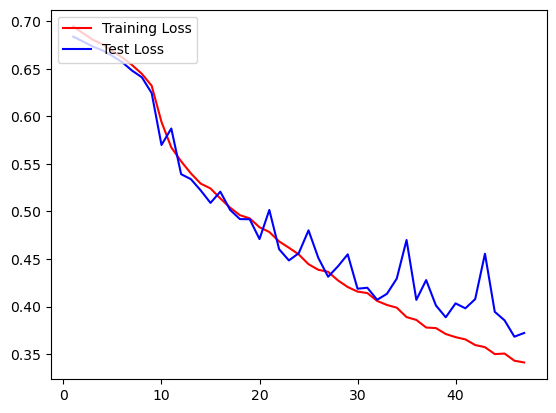

Epoch: 47 Train_Loss: 0.33869543457374024 Train_Accuracy: 0.852525
Epoch: 47 Test_Loss: 0.41413200014754187 Test_Accuracy: 0.8319


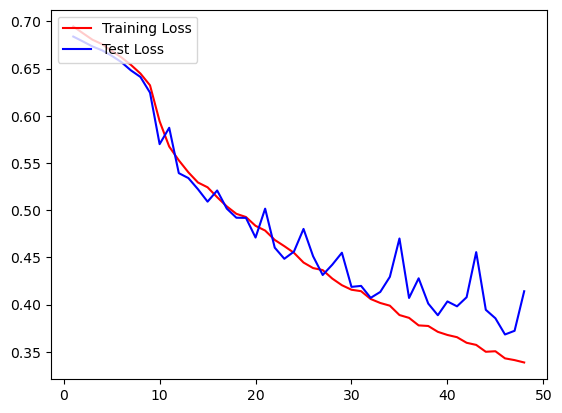

Epoch: 48 Train_Loss: 0.3367756916977727 Train_Accuracy: 0.854475
Epoch: 48 Test_Loss: 0.37988592589957804 Test_Accuracy: 0.8446


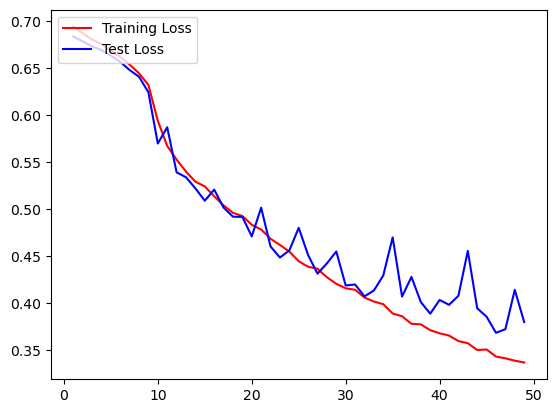

Epoch: 49 Train_Loss: 0.3370767135304003 Train_Accuracy: 0.854
Epoch: 49 Test_Loss: 0.37063369079481195 Test_Accuracy: 0.8484


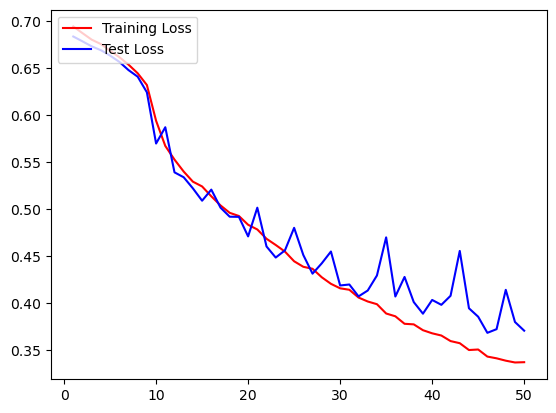

Epoch: 50 Train_Loss: 0.3291557466450591 Train_Accuracy: 0.8583
Epoch: 50 Test_Loss: 0.35933306681204447 Test_Accuracy: 0.8541


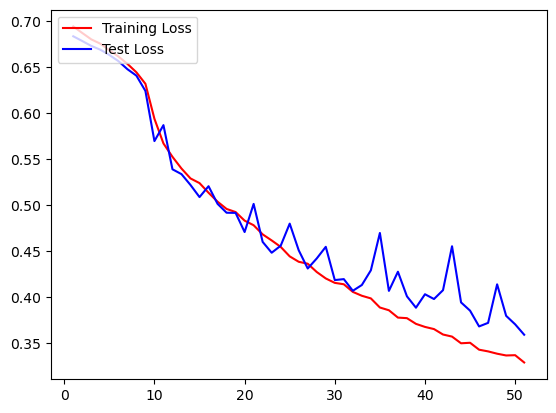

Epoch: 51 Train_Loss: 0.32497041174969354 Train_Accuracy: 0.86075
Epoch: 51 Test_Loss: 0.3840689757202245 Test_Accuracy: 0.8548


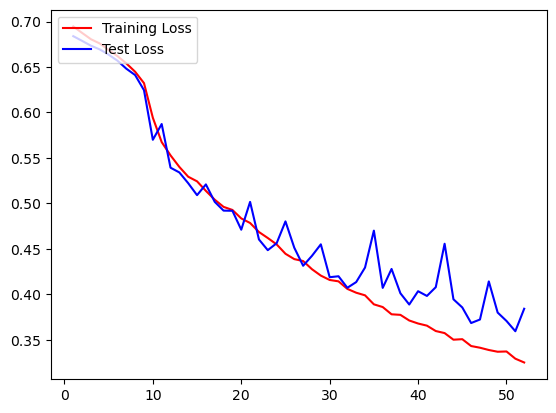

Epoch: 52 Train_Loss: 0.3218942746853295 Train_Accuracy: 0.860625
Epoch: 52 Test_Loss: 0.36239275411714483 Test_Accuracy: 0.8565


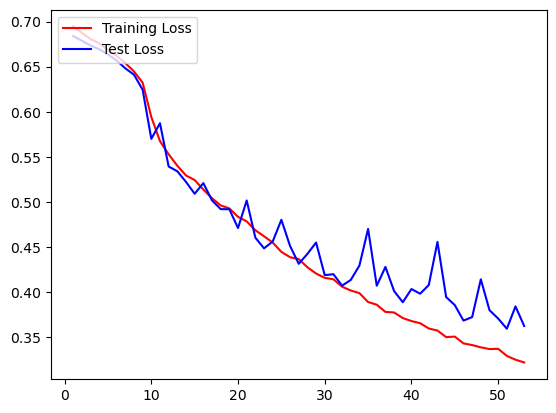

Epoch: 53 Train_Loss: 0.32503914299864356 Train_Accuracy: 0.860025
Epoch: 53 Test_Loss: 0.3769900842180735 Test_Accuracy: 0.8563


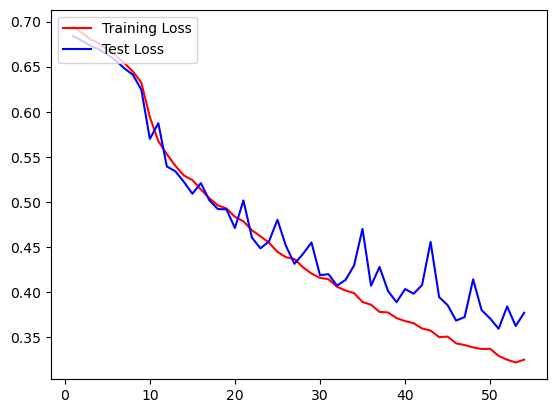

Epoch: 54 Train_Loss: 0.3214821965930561 Train_Accuracy: 0.862
Epoch: 54 Test_Loss: 0.3643270851690558 Test_Accuracy: 0.8512


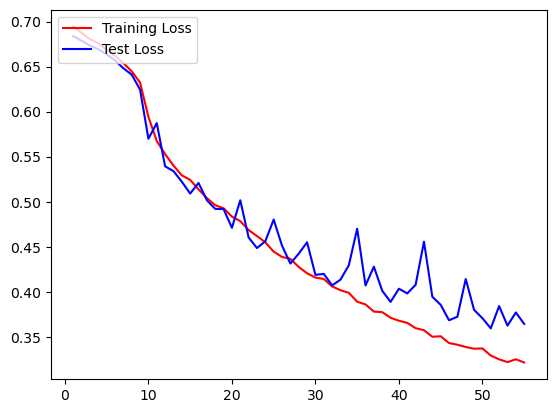

Epoch: 55 Train_Loss: 0.3124624863981058 Train_Accuracy: 0.8656
Epoch: 55 Test_Loss: 0.3666925707572623 Test_Accuracy: 0.8604


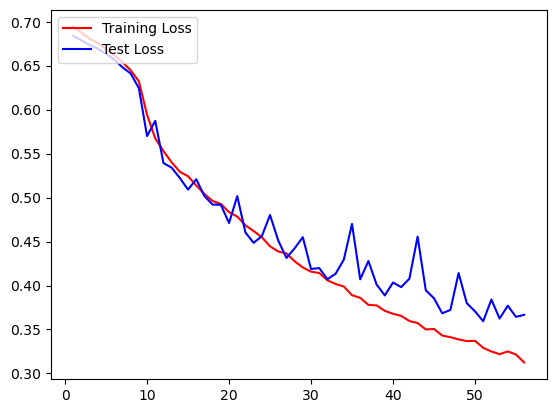

Epoch: 56 Train_Loss: 0.31097906513716844 Train_Accuracy: 0.869975
Epoch: 56 Test_Loss: 0.37654462381254267 Test_Accuracy: 0.8563


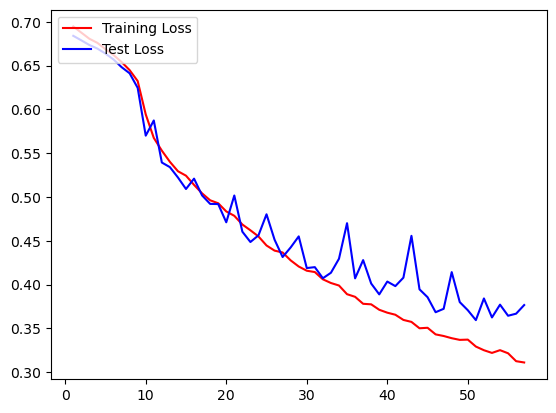

Epoch: 57 Train_Loss: 0.310302769747405 Train_Accuracy: 0.86845
Epoch: 57 Test_Loss: 0.39415085824984536 Test_Accuracy: 0.8537


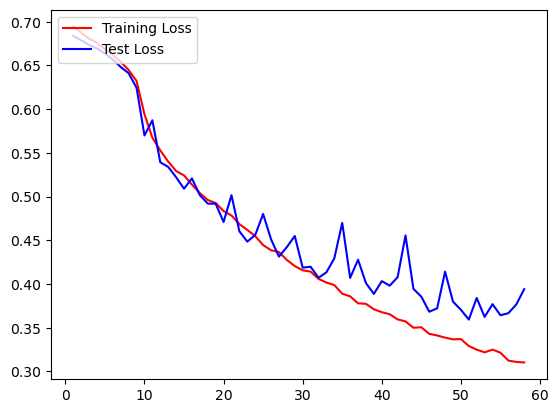

Epoch: 58 Train_Loss: 0.30863884248482154 Train_Accuracy: 0.870325
Epoch: 58 Test_Loss: 0.35413738311846044 Test_Accuracy: 0.8586


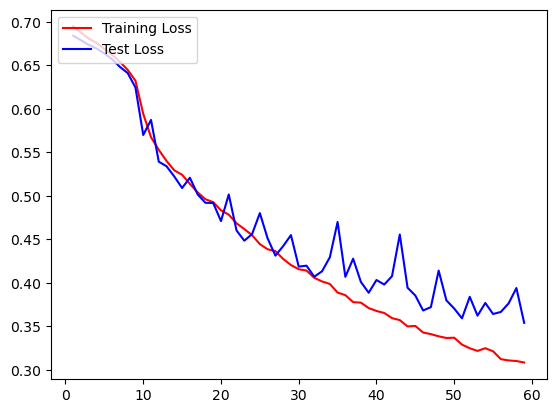

Epoch: 59 Train_Loss: 0.3046554500778643 Train_Accuracy: 0.87185
Epoch: 59 Test_Loss: 0.4008753858035124 Test_Accuracy: 0.8548


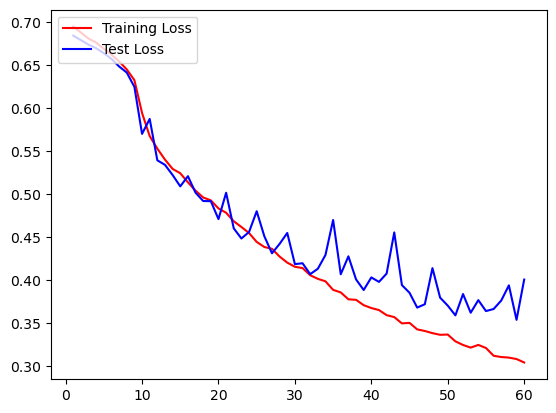

Epoch: 60 Train_Loss: 0.3069468295802704 Train_Accuracy: 0.8699
Epoch: 60 Test_Loss: 0.35186346610890157 Test_Accuracy: 0.8599


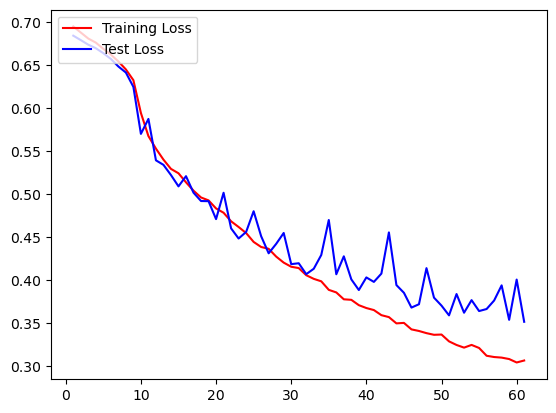

Epoch: 61 Train_Loss: 0.3000695165068197 Train_Accuracy: 0.872525
Epoch: 61 Test_Loss: 0.34825152403946164 Test_Accuracy: 0.8602


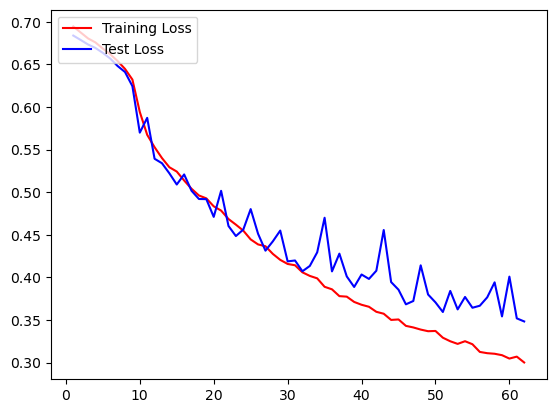

Epoch: 62 Train_Loss: 0.2967223786888793 Train_Accuracy: 0.87615
Epoch: 62 Test_Loss: 0.3471432726217222 Test_Accuracy: 0.8554


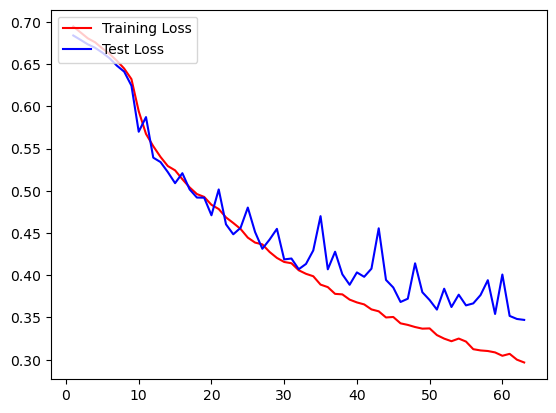

Epoch: 63 Train_Loss: 0.2958126261401862 Train_Accuracy: 0.876325
Epoch: 63 Test_Loss: 0.36763057621973977 Test_Accuracy: 0.8539


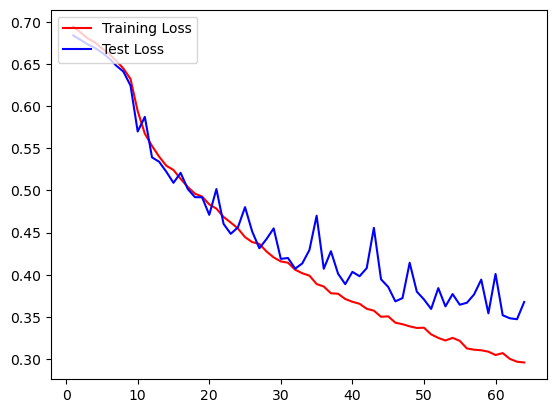

Epoch: 64 Train_Loss: 0.30564623104688077 Train_Accuracy: 0.8711
Epoch: 64 Test_Loss: 0.36574870593185665 Test_Accuracy: 0.8599


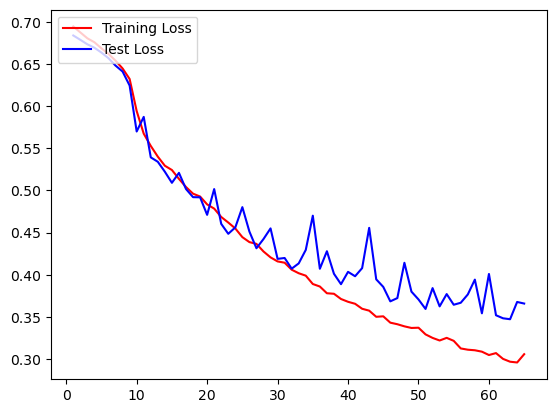

Epoch: 65 Train_Loss: 0.289713089125225 Train_Accuracy: 0.87825
Epoch: 65 Test_Loss: 0.38349659665475916 Test_Accuracy: 0.8619


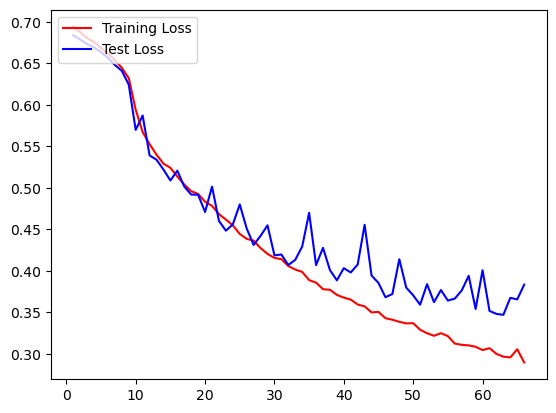

Epoch: 66 Train_Loss: 0.29482806124054967 Train_Accuracy: 0.874525
Epoch: 66 Test_Loss: 0.347067154283765 Test_Accuracy: 0.8654


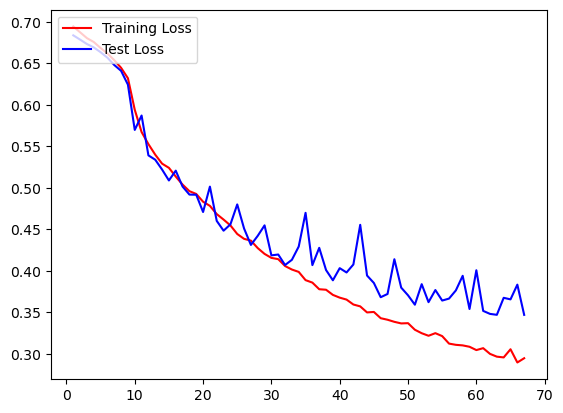

Epoch: 67 Train_Loss: 0.2905003858831363 Train_Accuracy: 0.879125
Epoch: 67 Test_Loss: 0.36904111297070225 Test_Accuracy: 0.8542


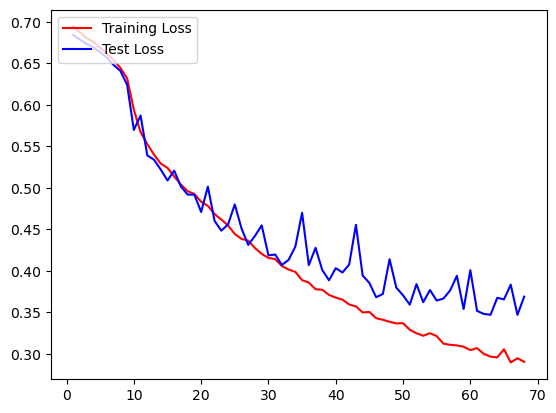

Epoch: 68 Train_Loss: 0.2818419057816362 Train_Accuracy: 0.883225
Epoch: 68 Test_Loss: 0.35598181527626666 Test_Accuracy: 0.8682


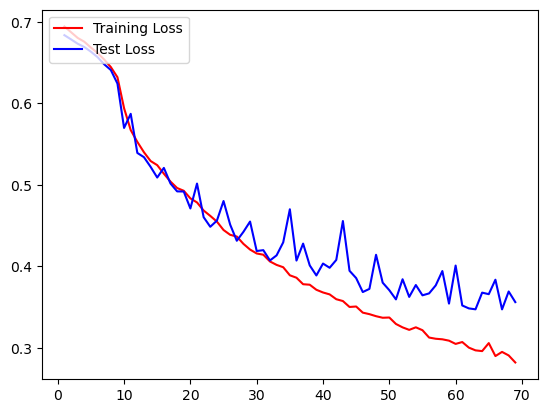

Epoch: 69 Train_Loss: 0.280722902796139 Train_Accuracy: 0.883925
Epoch: 69 Test_Loss: 0.35023459641239313 Test_Accuracy: 0.8645


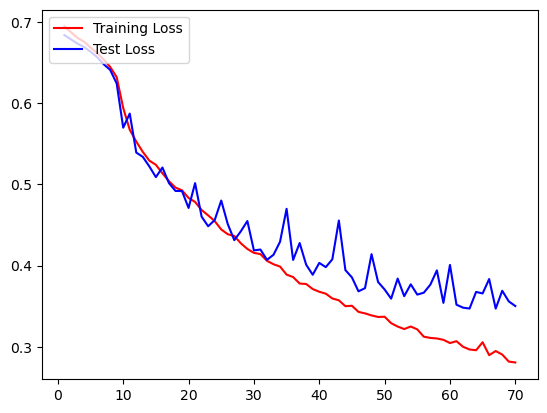

Epoch: 70 Train_Loss: 0.28243549429951387 Train_Accuracy: 0.8825
Epoch: 70 Test_Loss: 0.358871878513807 Test_Accuracy: 0.8684


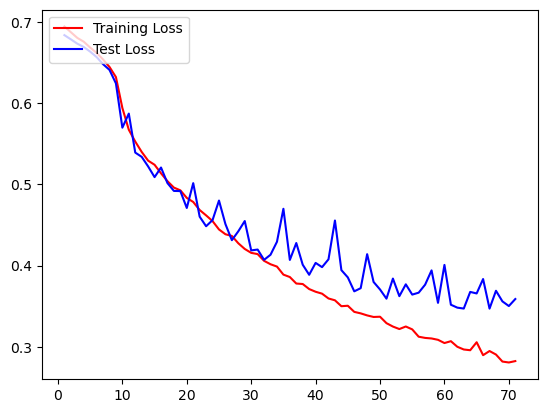

Epoch: 71 Train_Loss: 0.27887940097350283 Train_Accuracy: 0.8847
Epoch: 71 Test_Loss: 0.36431675243981276 Test_Accuracy: 0.8646


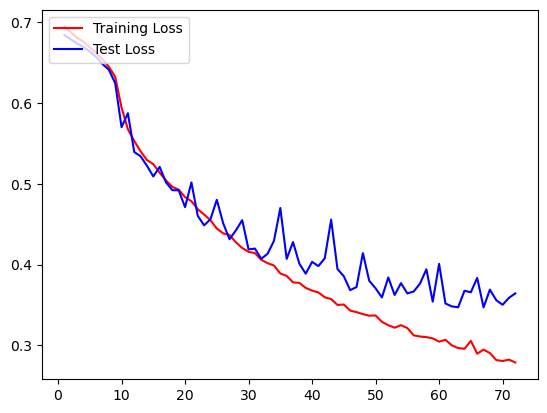

Epoch: 72 Train_Loss: 0.2756134263052346 Train_Accuracy: 0.886525
Epoch: 72 Test_Loss: 0.36144724978676324 Test_Accuracy: 0.866


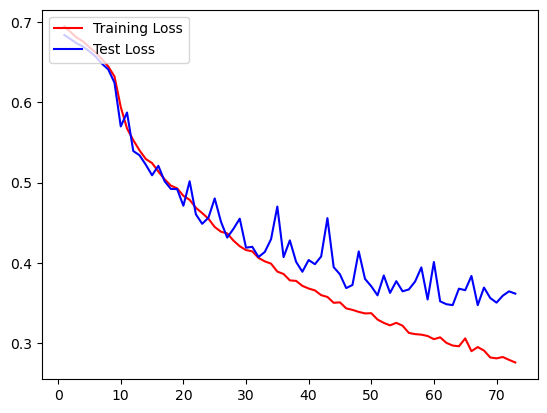

Epoch: 73 Train_Loss: 0.27840690757519904 Train_Accuracy: 0.88265
Epoch: 73 Test_Loss: 0.391264815496493 Test_Accuracy: 0.8619


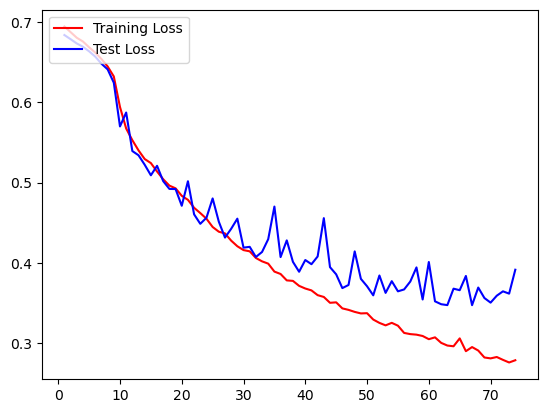

Epoch: 74 Train_Loss: 0.277688775485316 Train_Accuracy: 0.885375
Epoch: 74 Test_Loss: 0.3485993933451327 Test_Accuracy: 0.8694


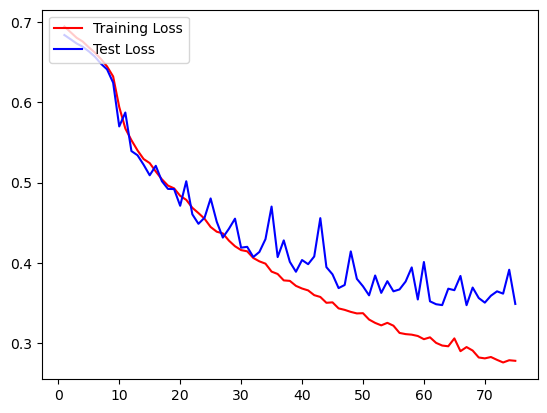

Epoch: 75 Train_Loss: 0.2734342973453168 Train_Accuracy: 0.8874
Epoch: 75 Test_Loss: 0.3375137248371221 Test_Accuracy: 0.8701


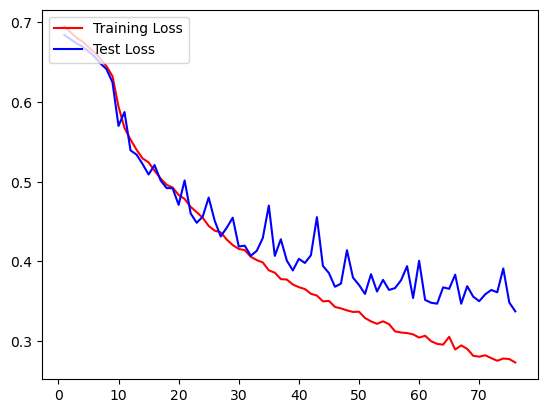

Epoch: 76 Train_Loss: 0.26716147063258355 Train_Accuracy: 0.890525
Epoch: 76 Test_Loss: 0.42767068592807916 Test_Accuracy: 0.8325


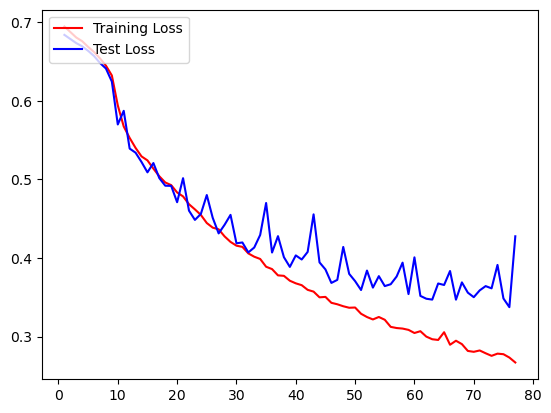

Epoch: 77 Train_Loss: 0.27198200146801554 Train_Accuracy: 0.8866
Epoch: 77 Test_Loss: 0.4109337552438808 Test_Accuracy: 0.854


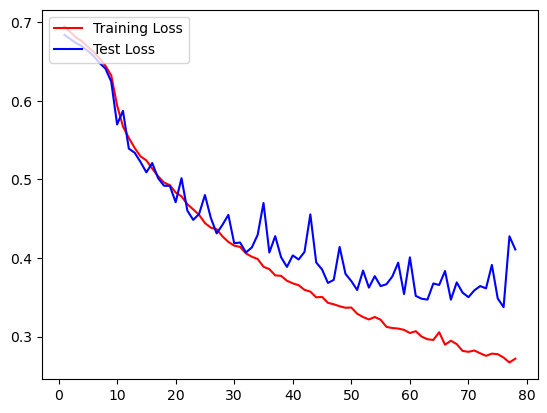

Epoch: 78 Train_Loss: 0.26540821219404664 Train_Accuracy: 0.891475
Epoch: 78 Test_Loss: 0.35888091106958026 Test_Accuracy: 0.8624


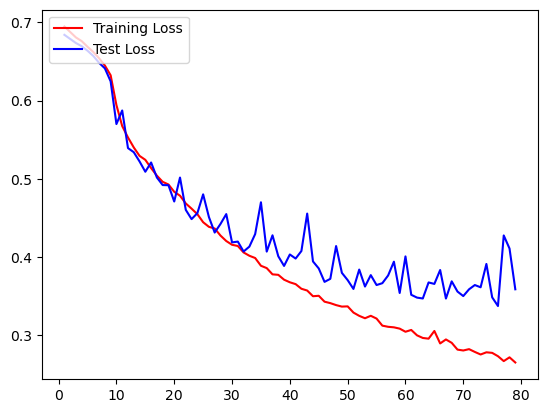

Epoch: 79 Train_Loss: 0.2660708076561602 Train_Accuracy: 0.890825
Epoch: 79 Test_Loss: 0.37237790076038507 Test_Accuracy: 0.8542


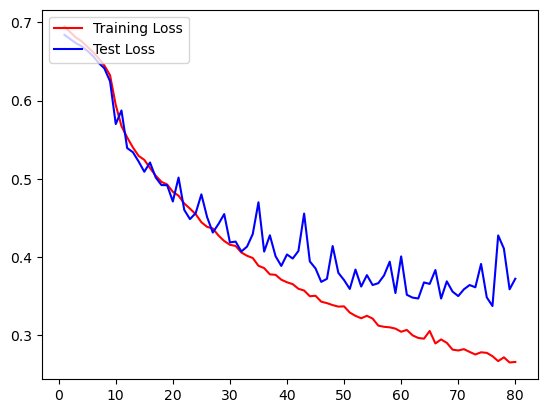

Epoch: 80 Train_Loss: 0.27550218870845467 Train_Accuracy: 0.8853
Epoch: 80 Test_Loss: 0.3563273275577569 Test_Accuracy: 0.8574


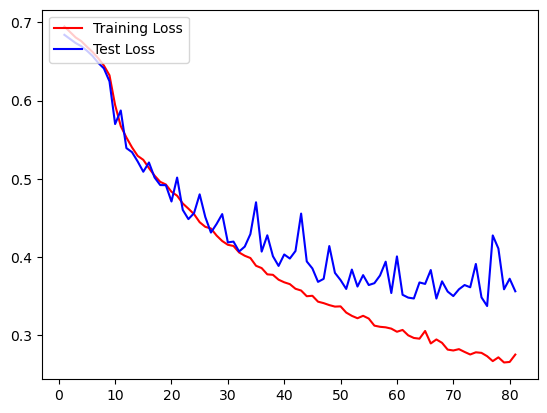

Epoch: 81 Train_Loss: 0.25888984007671617 Train_Accuracy: 0.894475
Epoch: 81 Test_Loss: 0.37241737110705314 Test_Accuracy: 0.8659


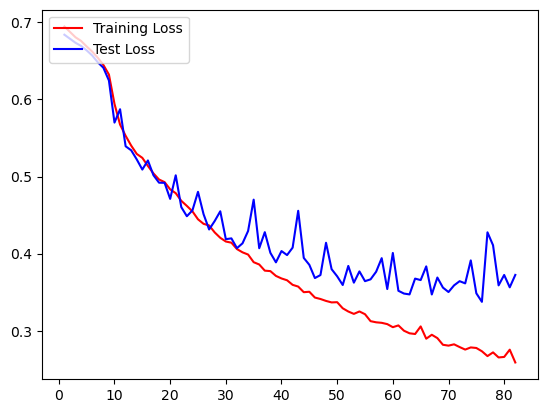

Epoch: 82 Train_Loss: 0.2577777006708014 Train_Accuracy: 0.8958
Epoch: 82 Test_Loss: 0.3772240962031521 Test_Accuracy: 0.8635


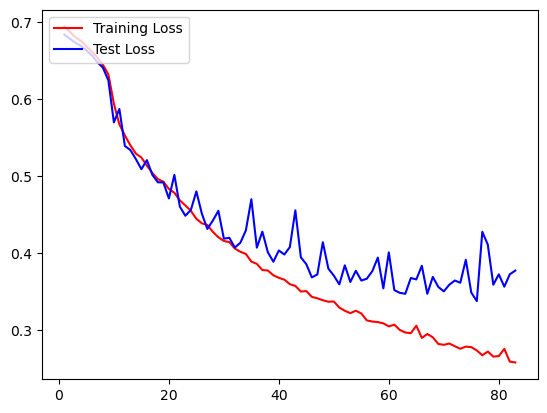

Epoch: 83 Train_Loss: 0.25561117959289126 Train_Accuracy: 0.898025
Epoch: 83 Test_Loss: 0.34270386133767383 Test_Accuracy: 0.8706


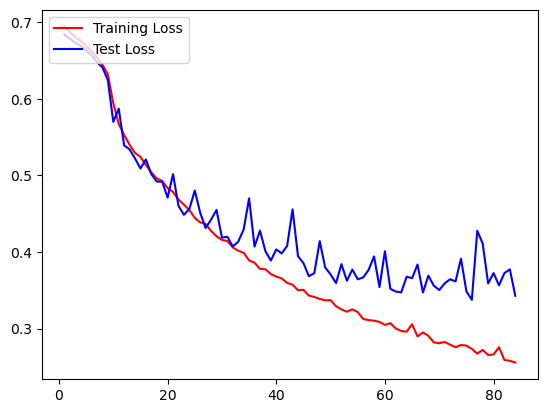

Epoch: 84 Train_Loss: 0.2595473596463188 Train_Accuracy: 0.895325
Epoch: 84 Test_Loss: 0.4427664374248891 Test_Accuracy: 0.8537


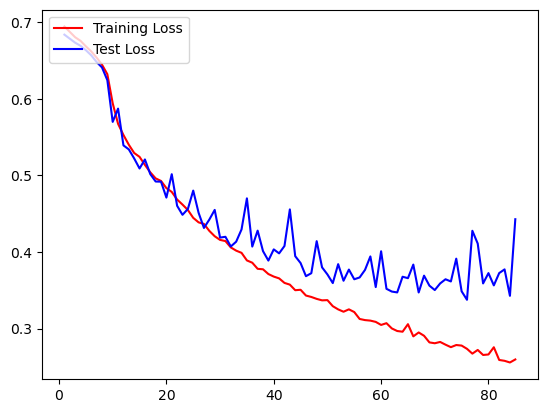

Epoch: 85 Train_Loss: 0.2536284363212677 Train_Accuracy: 0.896475
Epoch: 85 Test_Loss: 0.33486109349546556 Test_Accuracy: 0.871


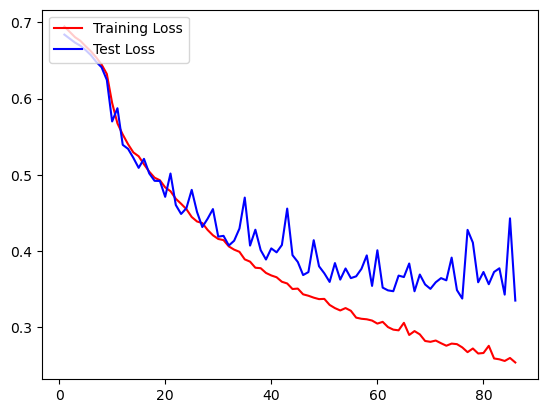

Epoch: 86 Train_Loss: 0.2564324739927682 Train_Accuracy: 0.895025
Epoch: 86 Test_Loss: 0.3563289602723303 Test_Accuracy: 0.8625


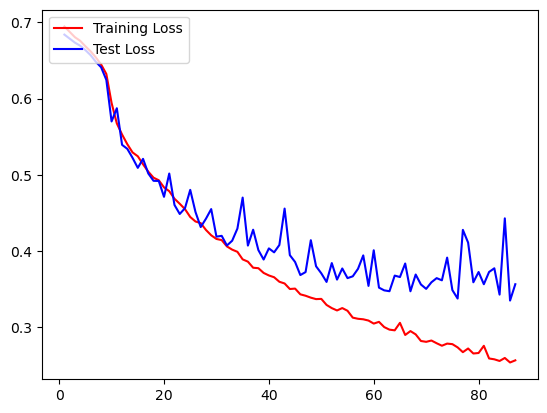

Epoch: 87 Train_Loss: 0.25157550543832324 Train_Accuracy: 0.898675
Epoch: 87 Test_Loss: 0.336126843773866 Test_Accuracy: 0.8731


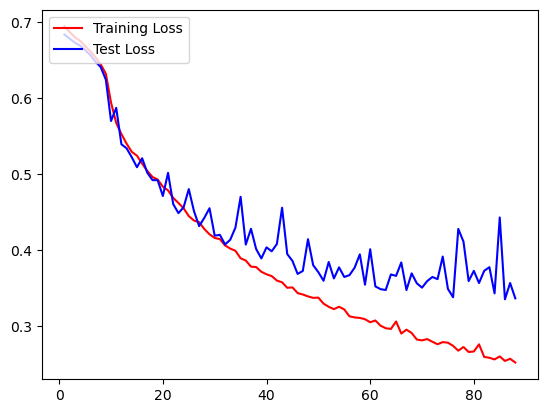

Epoch: 88 Train_Loss: 0.25019435898754927 Train_Accuracy: 0.898825
Epoch: 88 Test_Loss: 0.3486159821099873 Test_Accuracy: 0.8709


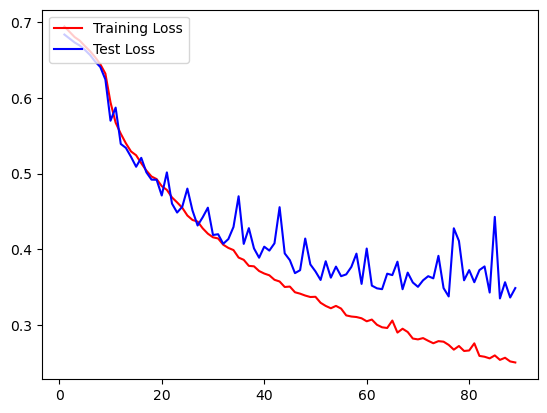

Epoch: 89 Train_Loss: 0.24764635366277574 Train_Accuracy: 0.90065
Epoch: 89 Test_Loss: 0.4003553613077236 Test_Accuracy: 0.8634


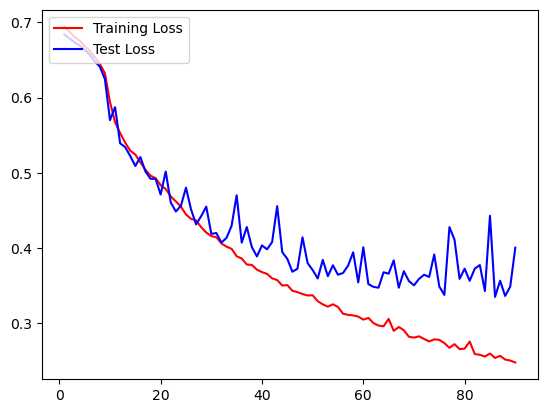

Epoch: 90 Train_Loss: 0.24775710801918285 Train_Accuracy: 0.9017
Epoch: 90 Test_Loss: 0.3385960346535791 Test_Accuracy: 0.8705


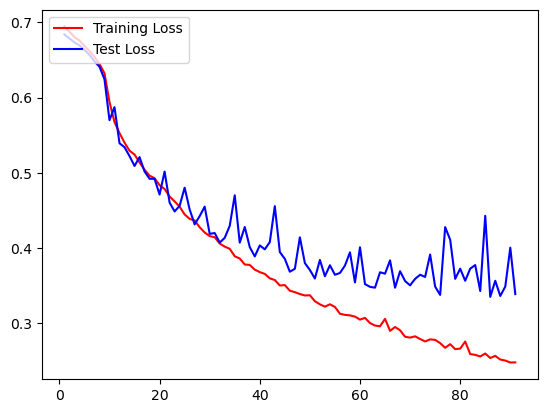

Epoch: 91 Train_Loss: 0.2475770674288844 Train_Accuracy: 0.8997
Epoch: 91 Test_Loss: 0.3340593700921988 Test_Accuracy: 0.8667


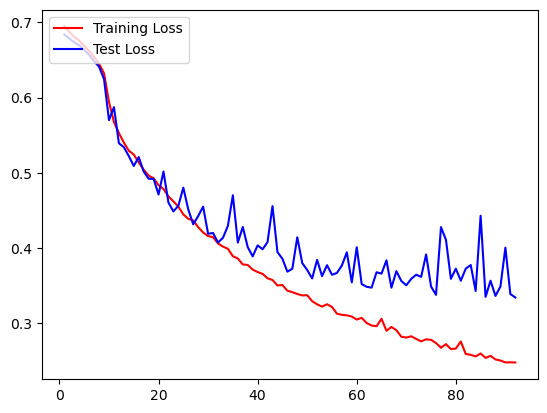

Epoch: 92 Train_Loss: 0.2404174550701254 Train_Accuracy: 0.903075
Epoch: 92 Test_Loss: 0.354682365173026 Test_Accuracy: 0.8696


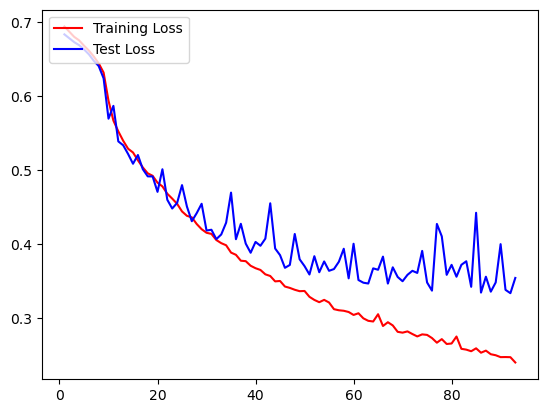

Epoch: 93 Train_Loss: 0.24259686593811353 Train_Accuracy: 0.902475
Epoch: 93 Test_Loss: 0.3641324741176412 Test_Accuracy: 0.873


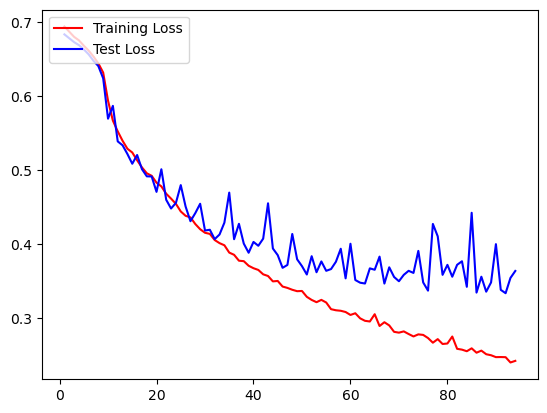

Epoch: 94 Train_Loss: 0.24639778324780753 Train_Accuracy: 0.900925
Epoch: 94 Test_Loss: 0.3479140572532823 Test_Accuracy: 0.8744


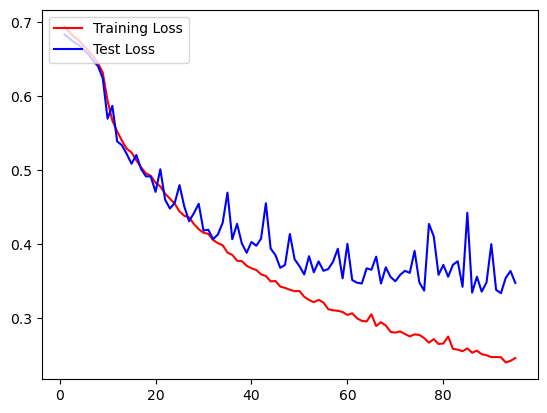

Epoch: 95 Train_Loss: 0.2395831783073017 Train_Accuracy: 0.905025
Epoch: 95 Test_Loss: 0.3906581937512265 Test_Accuracy: 0.8639


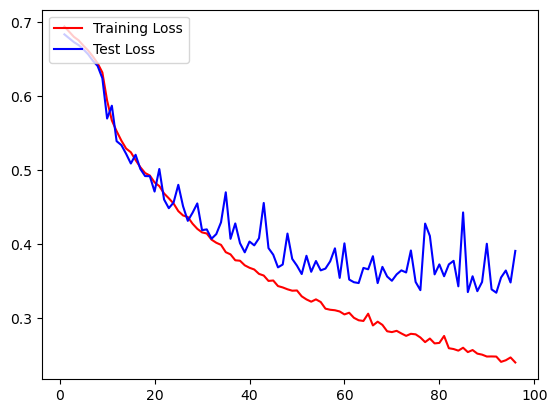

Epoch: 96 Train_Loss: 0.2445367345699487 Train_Accuracy: 0.9023
Epoch: 96 Test_Loss: 0.3391209493709516 Test_Accuracy: 0.8757


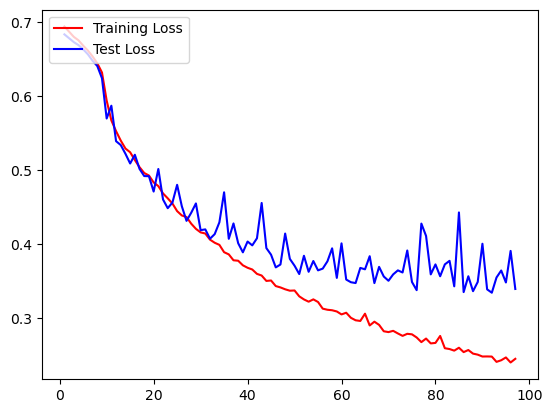

Epoch: 97 Train_Loss: 0.23956287154755274 Train_Accuracy: 0.90545
Epoch: 97 Test_Loss: 0.32703609594815897 Test_Accuracy: 0.8751


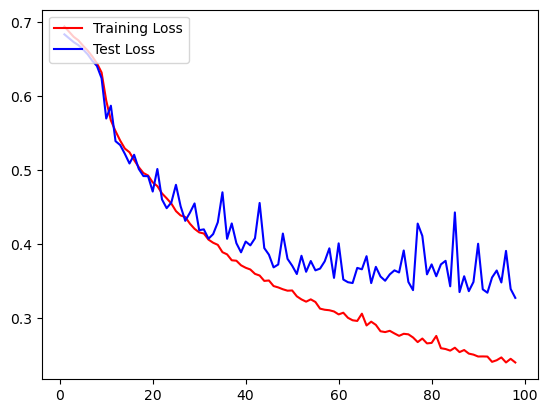

Epoch: 98 Train_Loss: 0.23343990878841747 Train_Accuracy: 0.9078
Epoch: 98 Test_Loss: 0.3398371055910859 Test_Accuracy: 0.8785


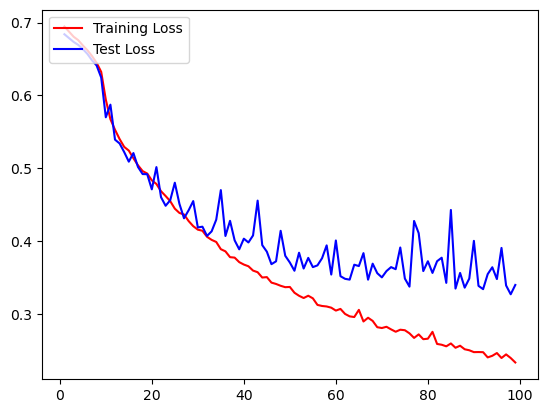

Epoch: 99 Train_Loss: 0.24168671129610592 Train_Accuracy: 0.902775
Epoch: 99 Test_Loss: 0.3464847150482709 Test_Accuracy: 0.8674


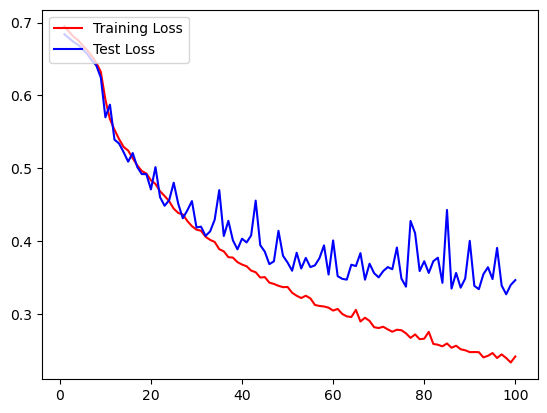

Epoch: 100 Train_Loss: 0.2345203271451088 Train_Accuracy: 0.907675
Epoch: 100 Test_Loss: 0.3631926914559135 Test_Accuracy: 0.8725


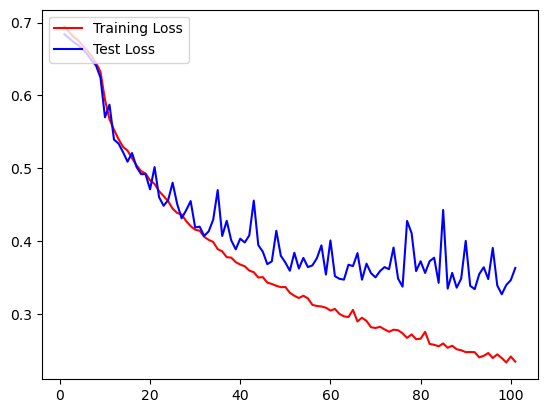

Epoch: 101 Train_Loss: 0.22785096867872884 Train_Accuracy: 0.910125
Epoch: 101 Test_Loss: 0.34475913907908184 Test_Accuracy: 0.8775


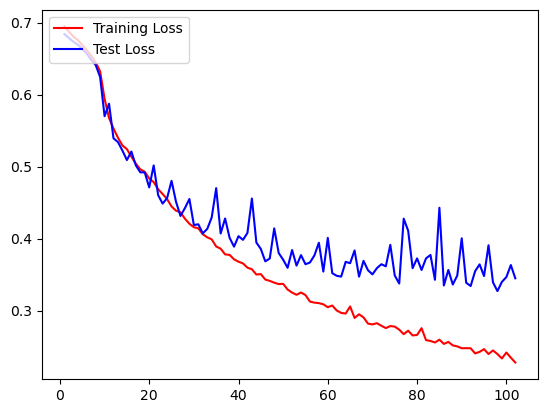

Epoch: 102 Train_Loss: 0.22774631332475156 Train_Accuracy: 0.910025
Epoch: 102 Test_Loss: 0.3426070443437069 Test_Accuracy: 0.875


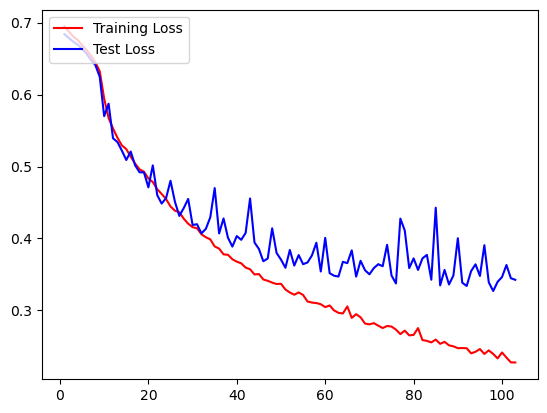

Epoch: 103 Train_Loss: 0.22282292474858678 Train_Accuracy: 0.91235
Epoch: 103 Test_Loss: 0.3421817337033115 Test_Accuracy: 0.8724


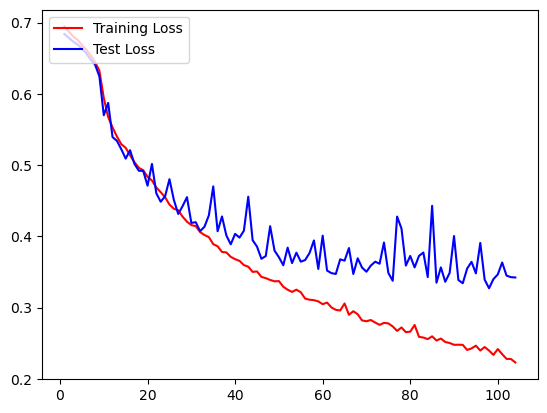

Epoch: 104 Train_Loss: 0.22801353641973135 Train_Accuracy: 0.91015
Epoch: 104 Test_Loss: 0.34423240019550805 Test_Accuracy: 0.8779


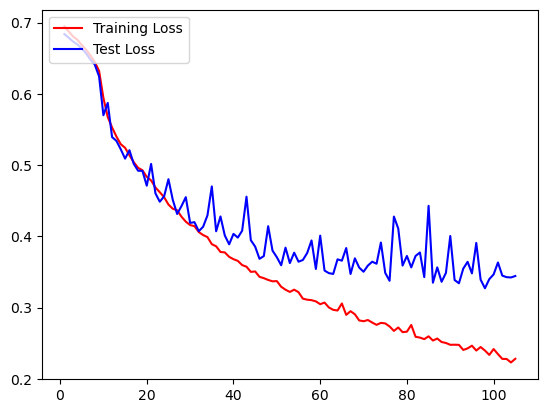

Epoch: 105 Train_Loss: 0.2246365270342309 Train_Accuracy: 0.9116
Epoch: 105 Test_Loss: 0.37719059235687497 Test_Accuracy: 0.8722


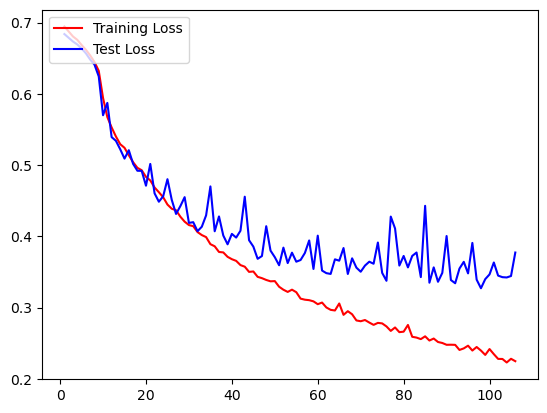

Epoch: 106 Train_Loss: 0.2210600873389945 Train_Accuracy: 0.913175
Epoch: 106 Test_Loss: 0.3316902720098254 Test_Accuracy: 0.8783


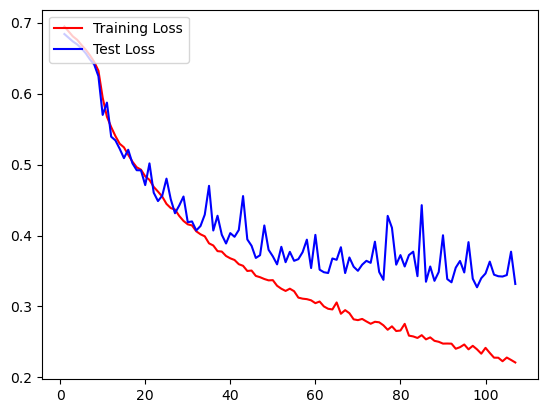

Epoch: 107 Train_Loss: 0.22142703393206428 Train_Accuracy: 0.914325
Epoch: 107 Test_Loss: 0.34037230003483687 Test_Accuracy: 0.8763


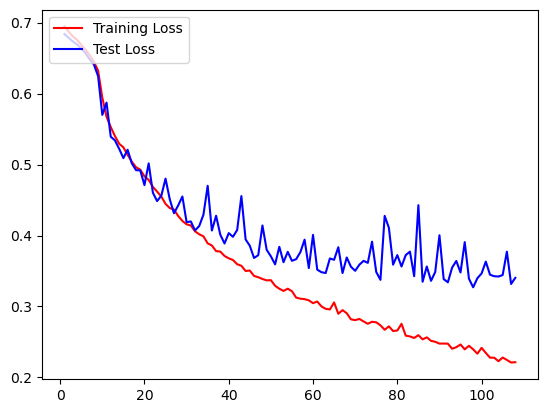

Epoch: 108 Train_Loss: 0.2215929630036933 Train_Accuracy: 0.9136
Epoch: 108 Test_Loss: 0.347215395939501 Test_Accuracy: 0.8705


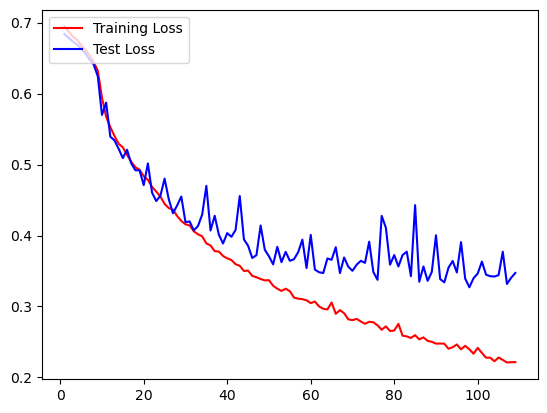

Epoch: 109 Train_Loss: 0.21949730085107846 Train_Accuracy: 0.915075
Epoch: 109 Test_Loss: 0.3503451850972598 Test_Accuracy: 0.8778


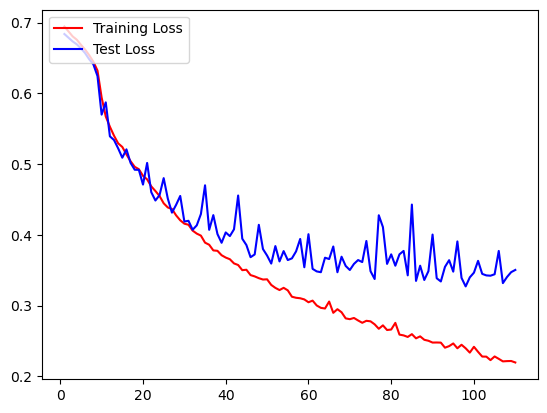

Epoch: 110 Train_Loss: 0.2186270735848445 Train_Accuracy: 0.91515
Epoch: 110 Test_Loss: 0.3961758400443234 Test_Accuracy: 0.8664


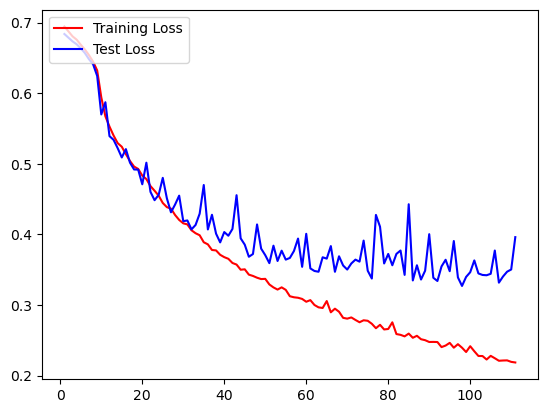

Epoch: 111 Train_Loss: 0.21562622404231813 Train_Accuracy: 0.91595
Epoch: 111 Test_Loss: 0.34949612900426114 Test_Accuracy: 0.8737


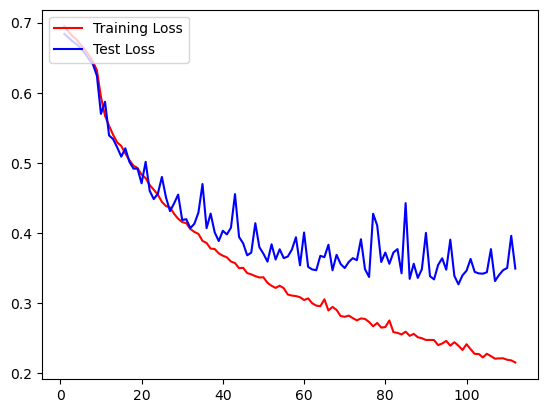

Epoch: 112 Train_Loss: 0.21570595149129343 Train_Accuracy: 0.916375
Epoch: 112 Test_Loss: 0.3742352652398846 Test_Accuracy: 0.8719


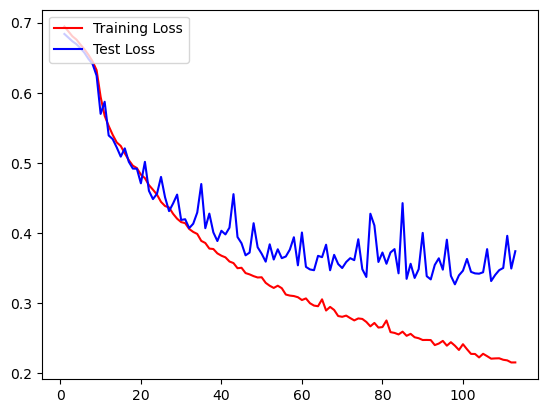

Epoch: 113 Train_Loss: 0.23287020937893718 Train_Accuracy: 0.909425
Epoch: 113 Test_Loss: 0.36291015544269656 Test_Accuracy: 0.8731


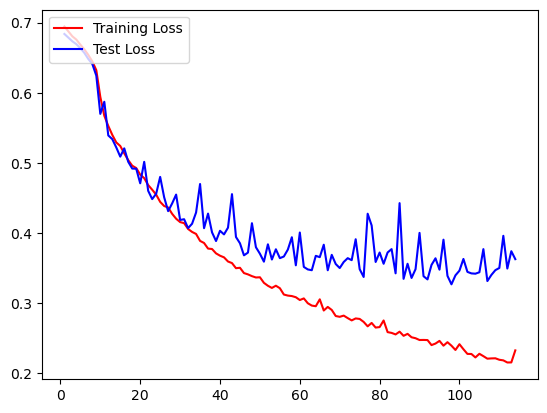

Epoch: 114 Train_Loss: 0.21593350360092645 Train_Accuracy: 0.9155
Epoch: 114 Test_Loss: 0.37882656236238116 Test_Accuracy: 0.8669


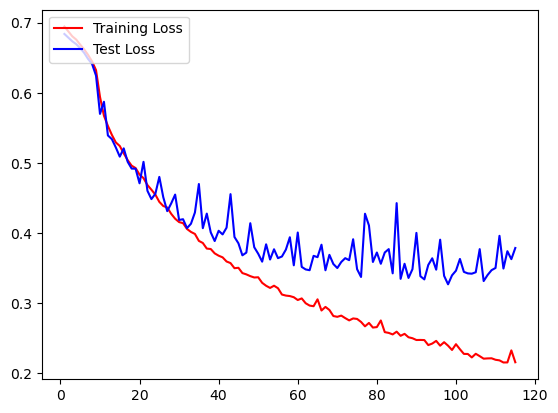

Epoch: 115 Train_Loss: 0.21079508115213139 Train_Accuracy: 0.91835
Epoch: 115 Test_Loss: 0.3464766684212262 Test_Accuracy: 0.8733


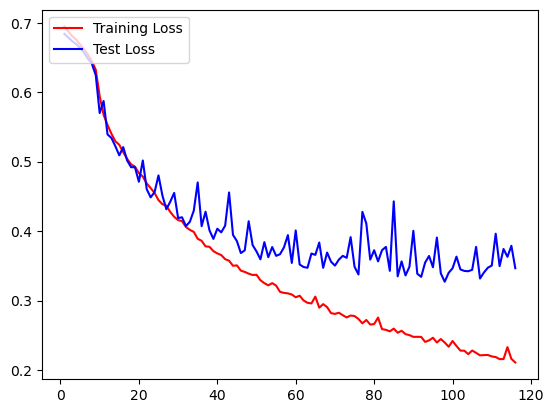

Epoch: 116 Train_Loss: 0.20469292800742597 Train_Accuracy: 0.92055
Epoch: 116 Test_Loss: 0.3620156030866164 Test_Accuracy: 0.8762


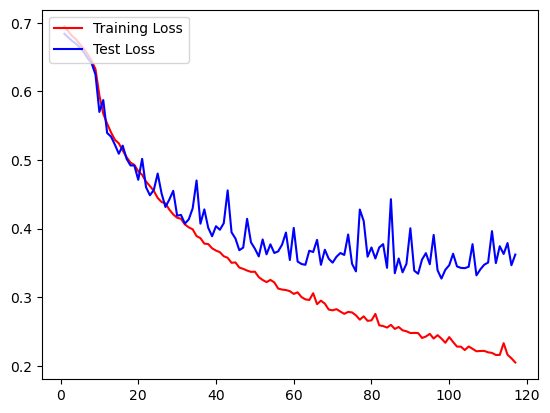

Epoch: 117 Train_Loss: 0.2041065566265545 Train_Accuracy: 0.921625
Epoch: 117 Test_Loss: 0.3644632193483884 Test_Accuracy: 0.8774


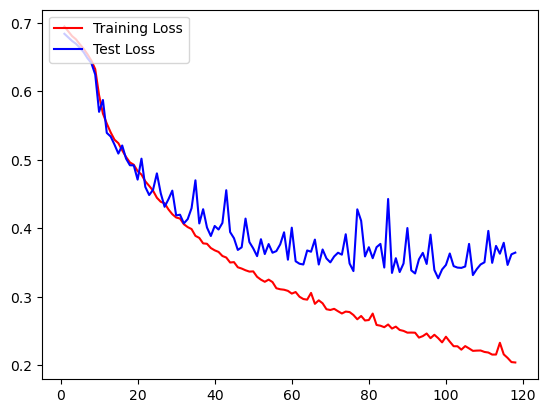

Epoch: 118 Train_Loss: 0.20944578302934908 Train_Accuracy: 0.9194
Epoch: 118 Test_Loss: 0.3867463233727443 Test_Accuracy: 0.8639


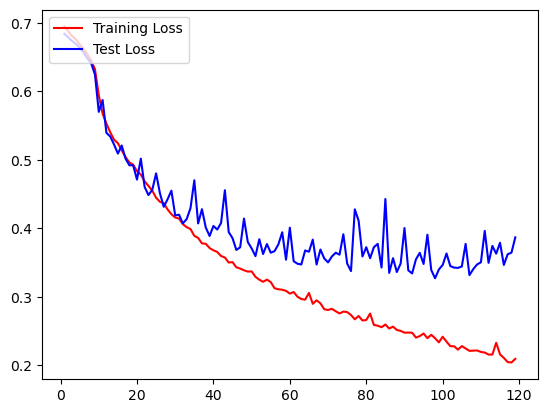

Epoch: 119 Train_Loss: 0.20328264374035998 Train_Accuracy: 0.921975
Epoch: 119 Test_Loss: 0.3860206943524035 Test_Accuracy: 0.8721


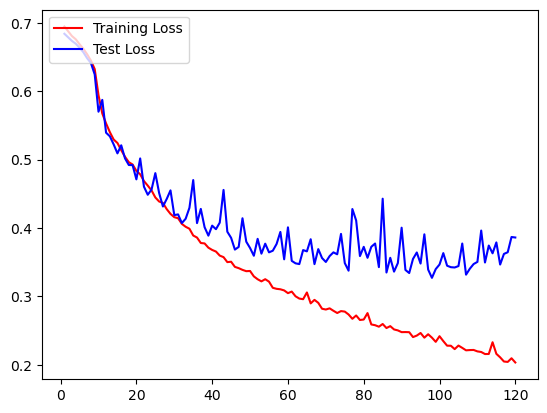

Epoch: 120 Train_Loss: 0.2041885824487232 Train_Accuracy: 0.922825
Epoch: 120 Test_Loss: 0.38065942706941047 Test_Accuracy: 0.8623


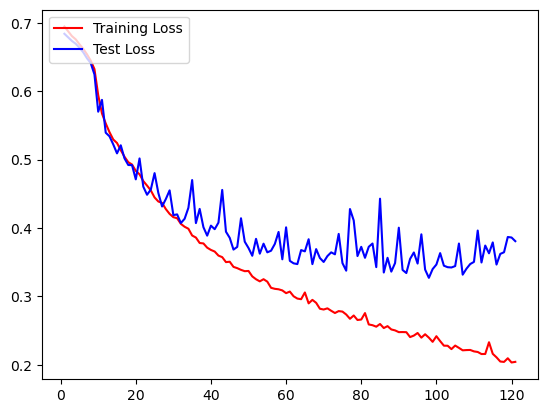

Epoch: 121 Train_Loss: 0.20578224528521394 Train_Accuracy: 0.91965
Epoch: 121 Test_Loss: 0.348167612960067 Test_Accuracy: 0.8775


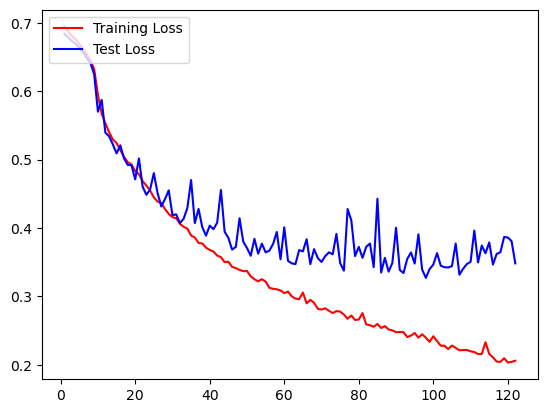

Epoch: 122 Train_Loss: 0.20594908854070182 Train_Accuracy: 0.920675
Epoch: 122 Test_Loss: 0.3695268346161782 Test_Accuracy: 0.8615


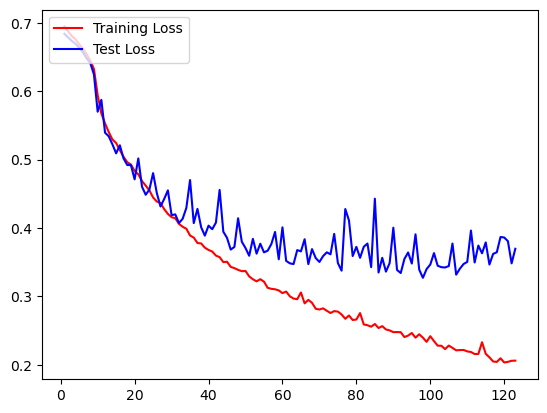

Epoch: 123 Train_Loss: 0.19812858685517845 Train_Accuracy: 0.92435
Epoch: 123 Test_Loss: 0.3431323055602327 Test_Accuracy: 0.877


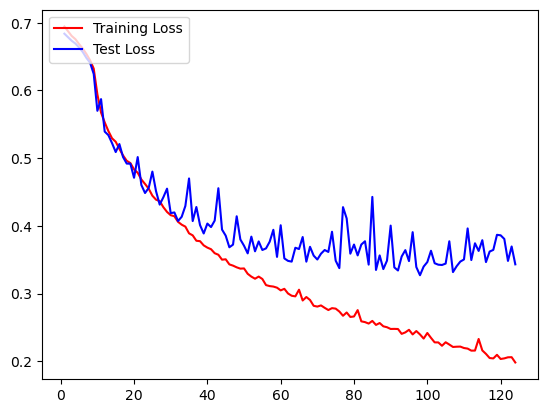

Epoch: 124 Train_Loss: 0.19980710190229903 Train_Accuracy: 0.923625
Epoch: 124 Test_Loss: 0.37025582243370103 Test_Accuracy: 0.8758


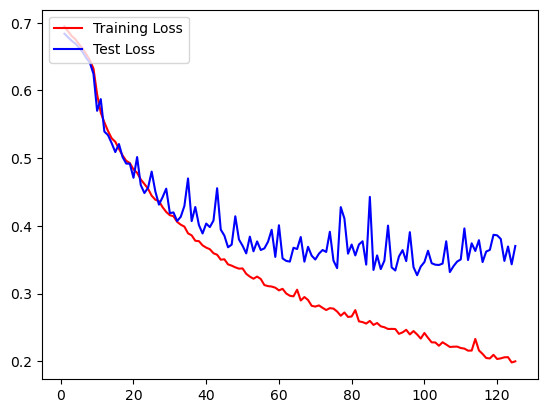

Epoch: 125 Train_Loss: 0.1981981442378352 Train_Accuracy: 0.924775
Epoch: 125 Test_Loss: 0.3619353143097479 Test_Accuracy: 0.8697


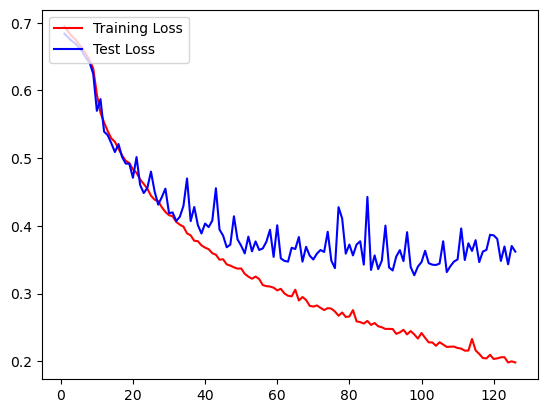

Epoch: 126 Train_Loss: 0.20301419736954351 Train_Accuracy: 0.921
Epoch: 126 Test_Loss: 0.38747840214379226 Test_Accuracy: 0.8538


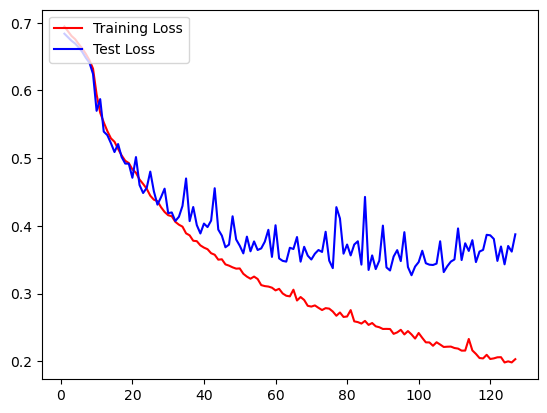

Epoch: 127 Train_Loss: 0.19615126879641803 Train_Accuracy: 0.925925
Epoch: 127 Test_Loss: 0.38769498052476326 Test_Accuracy: 0.8723


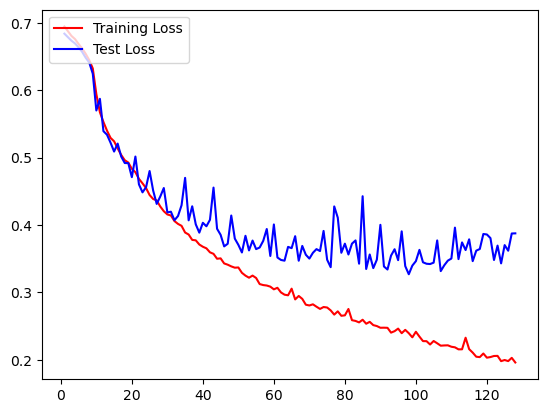

Epoch: 128 Train_Loss: 0.19943155443516022 Train_Accuracy: 0.922575
Epoch: 128 Test_Loss: 0.38263509243349486 Test_Accuracy: 0.878


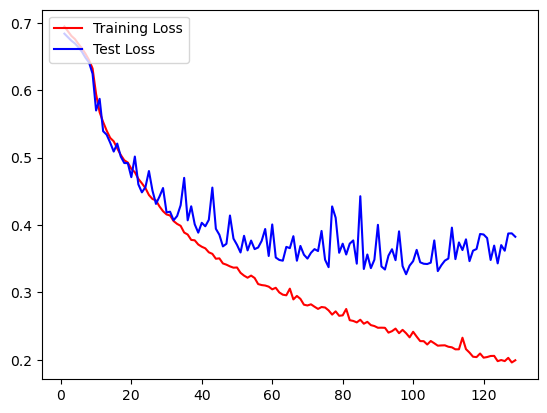

Epoch: 129 Train_Loss: 0.19543527121456286 Train_Accuracy: 0.9259
Epoch: 129 Test_Loss: 0.3399715199123455 Test_Accuracy: 0.8802


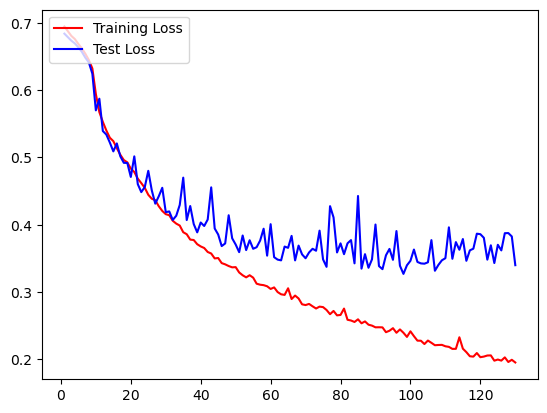

Epoch: 130 Train_Loss: 0.19097578758820177 Train_Accuracy: 0.928575
Epoch: 130 Test_Loss: 0.3873214621709872 Test_Accuracy: 0.874


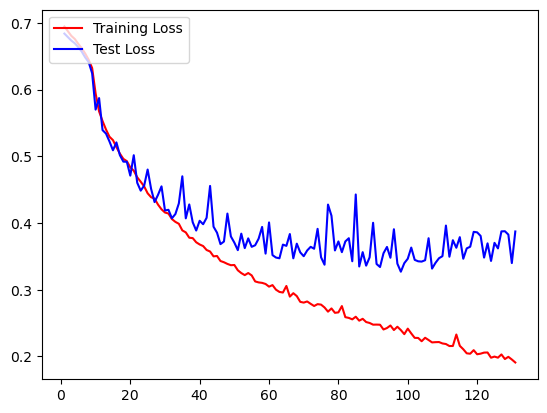

Epoch: 131 Train_Loss: 0.19348269091627468 Train_Accuracy: 0.926725
Epoch: 131 Test_Loss: 0.43830544039418423 Test_Accuracy: 0.8552


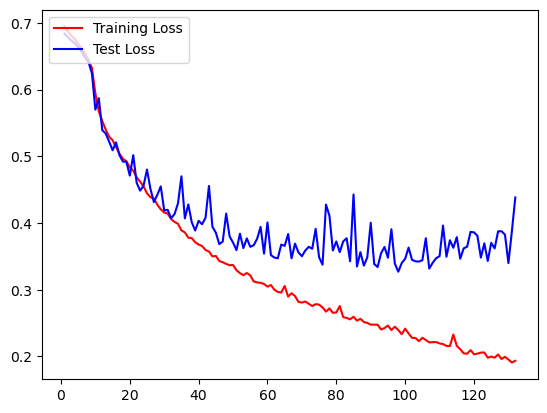

Epoch: 132 Train_Loss: 0.19180232434036631 Train_Accuracy: 0.9275
Epoch: 132 Test_Loss: 0.3949393388591235 Test_Accuracy: 0.8706


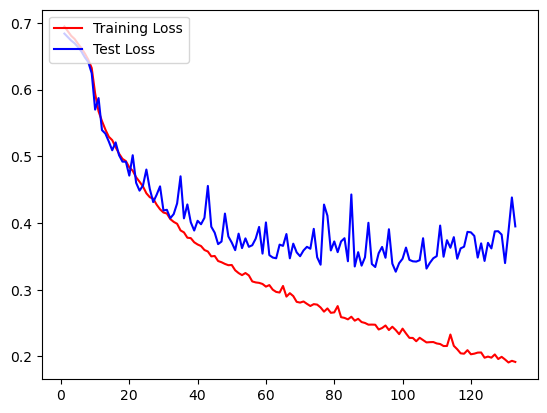

Epoch: 133 Train_Loss: 0.18872036232639805 Train_Accuracy: 0.929425
Epoch: 133 Test_Loss: 0.3665624381620673 Test_Accuracy: 0.8751


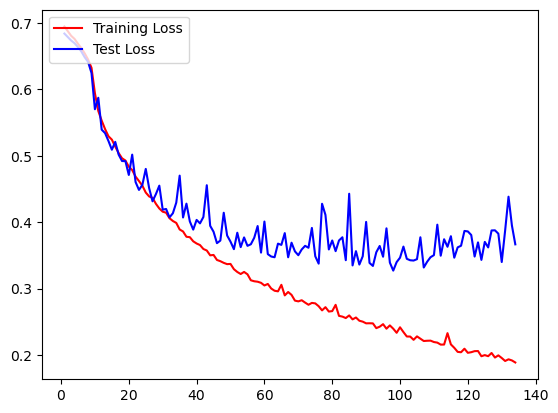

Epoch: 134 Train_Loss: 0.1918261812422603 Train_Accuracy: 0.927575
Epoch: 134 Test_Loss: 0.3196191927300224 Test_Accuracy: 0.8816


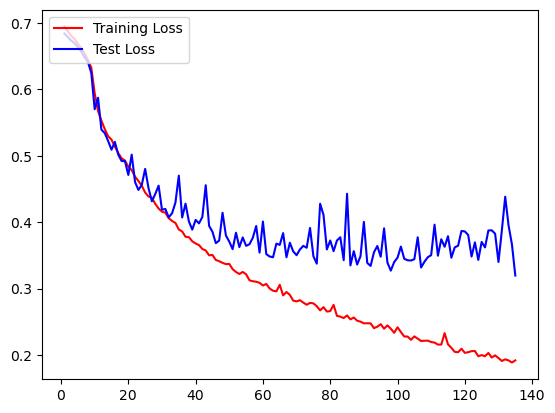

Epoch: 135 Train_Loss: 0.1890829161237985 Train_Accuracy: 0.929475
Epoch: 135 Test_Loss: 0.36801974249037006 Test_Accuracy: 0.88


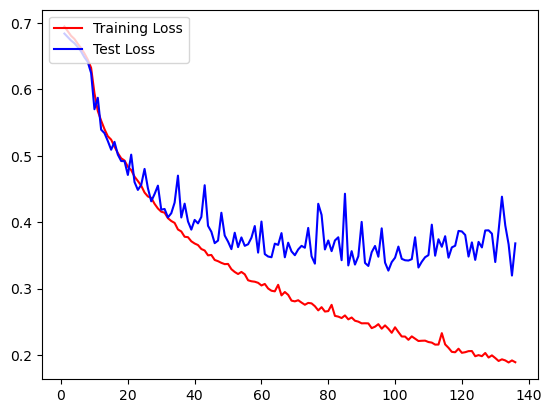

Epoch: 136 Train_Loss: 0.18976332659062486 Train_Accuracy: 0.927975
Epoch: 136 Test_Loss: 0.3793453255408927 Test_Accuracy: 0.8714


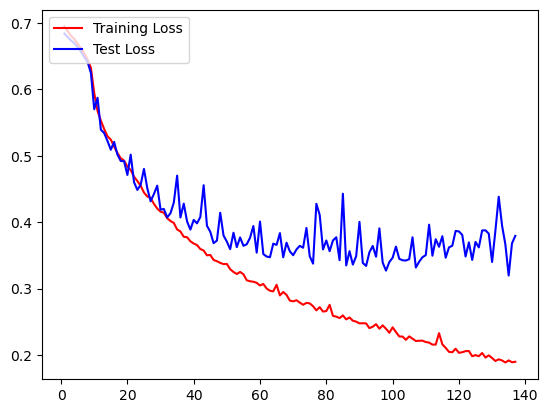

Epoch: 137 Train_Loss: 0.1854073382652225 Train_Accuracy: 0.9297
Epoch: 137 Test_Loss: 0.33857429857495464 Test_Accuracy: 0.8802


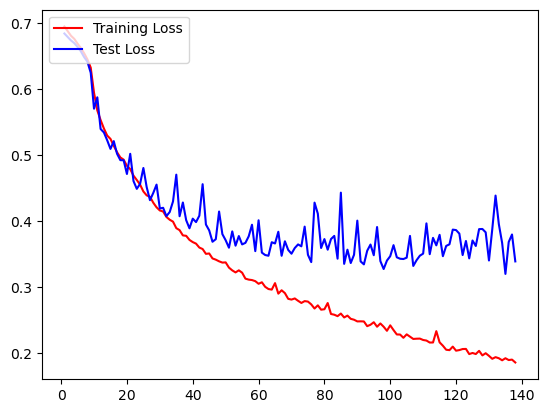

Epoch: 138 Train_Loss: 0.18473390080391788 Train_Accuracy: 0.93115
Epoch: 138 Test_Loss: 0.3398826103421706 Test_Accuracy: 0.8839


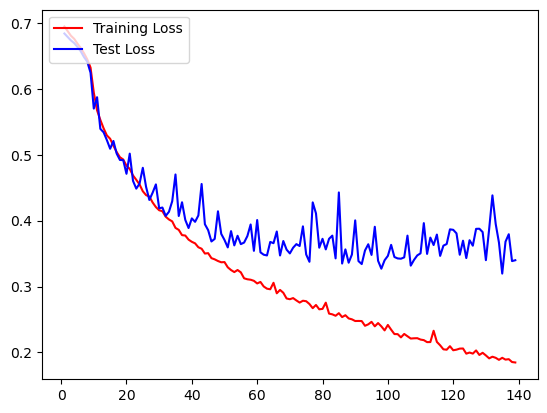

Epoch: 139 Train_Loss: 0.183163648286757 Train_Accuracy: 0.9312
Epoch: 139 Test_Loss: 0.3525495791359793 Test_Accuracy: 0.882


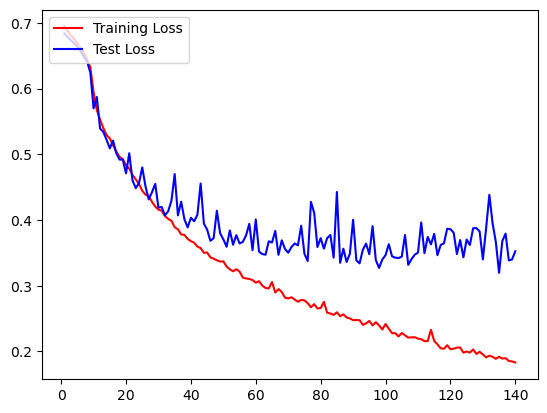

Epoch: 140 Train_Loss: 0.18029484590783287 Train_Accuracy: 0.931825
Epoch: 140 Test_Loss: 0.3740493200625045 Test_Accuracy: 0.8775


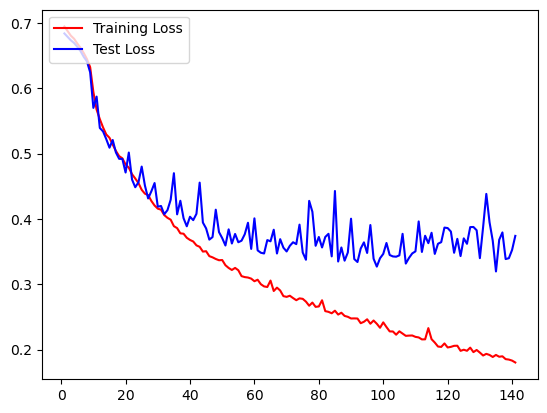

Epoch: 141 Train_Loss: 0.18647523150562098 Train_Accuracy: 0.930625
Epoch: 141 Test_Loss: 0.3594639703065534 Test_Accuracy: 0.8724


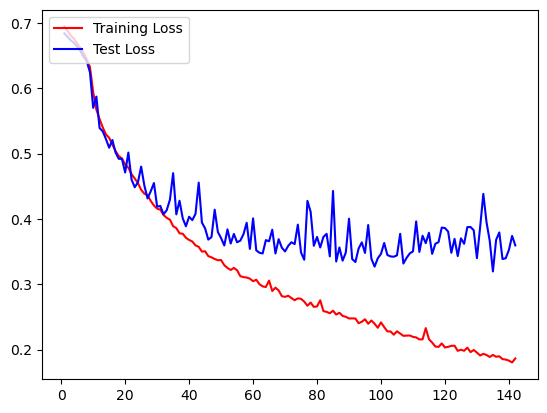

Epoch: 142 Train_Loss: 0.18300574288343469 Train_Accuracy: 0.931525
Epoch: 142 Test_Loss: 0.39942220155196856 Test_Accuracy: 0.8687


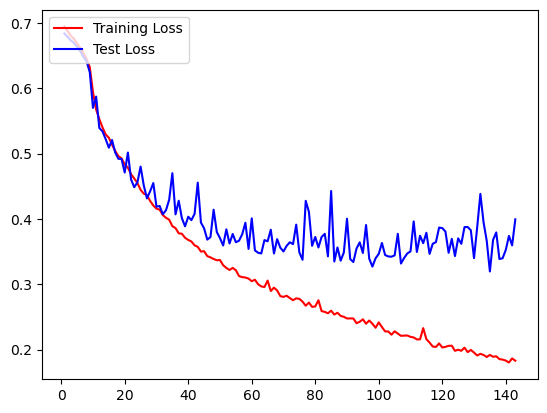

Epoch: 143 Train_Loss: 0.17907853060351392 Train_Accuracy: 0.93335
Epoch: 143 Test_Loss: 0.35086116817178603 Test_Accuracy: 0.8792


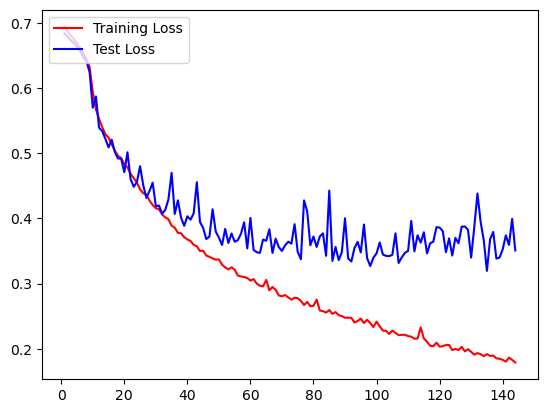

Epoch: 144 Train_Loss: 0.17947490344317957 Train_Accuracy: 0.93295
Epoch: 144 Test_Loss: 0.35426075775412064 Test_Accuracy: 0.8791


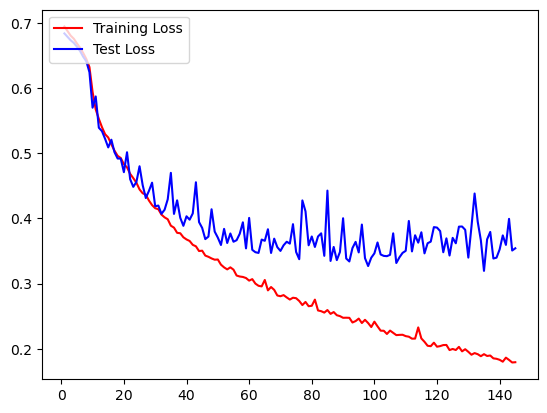

Epoch: 145 Train_Loss: 0.17833592116642302 Train_Accuracy: 0.934125
Epoch: 145 Test_Loss: 0.352332282292692 Test_Accuracy: 0.877


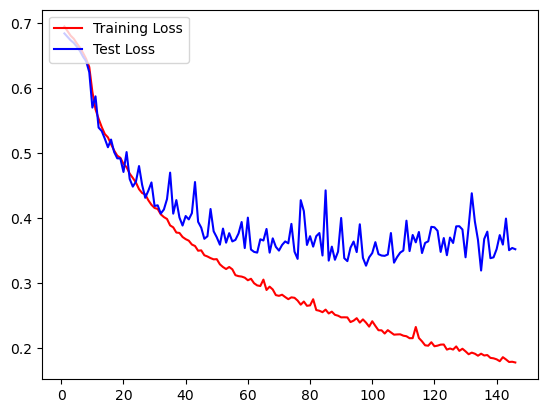

Epoch: 146 Train_Loss: 0.1785648902669882 Train_Accuracy: 0.932625
Epoch: 146 Test_Loss: 0.38210271298885345 Test_Accuracy: 0.8672


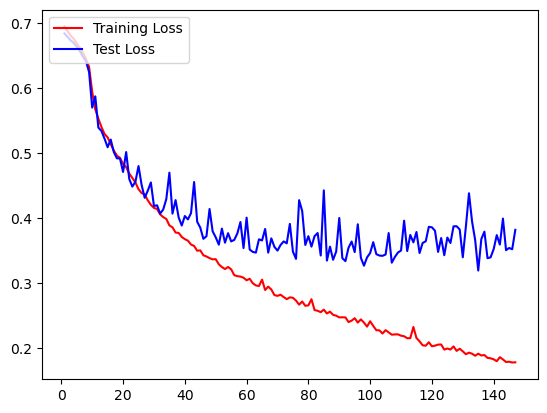

Epoch: 147 Train_Loss: 0.17444754526399955 Train_Accuracy: 0.93545
Epoch: 147 Test_Loss: 0.34221072174325773 Test_Accuracy: 0.8801


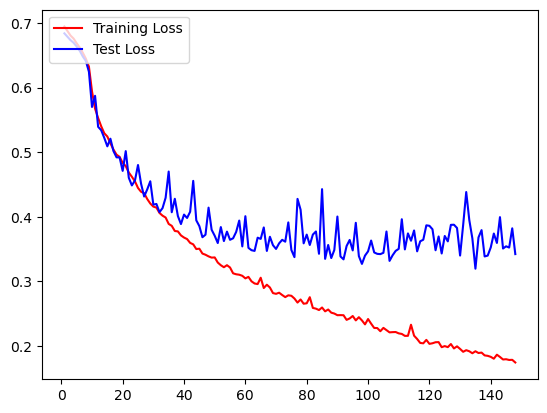

Epoch: 148 Train_Loss: 0.18178185016012038 Train_Accuracy: 0.9305
Epoch: 148 Test_Loss: 0.3714735034523131 Test_Accuracy: 0.8655


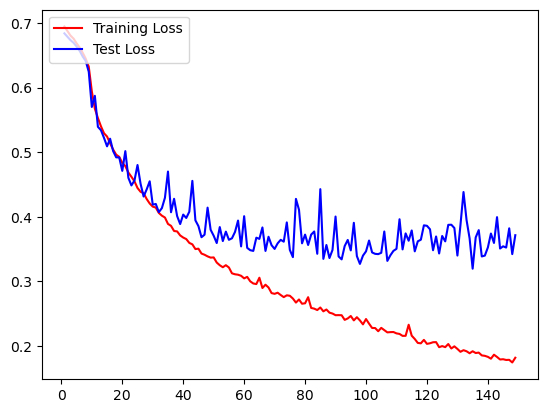

Epoch: 149 Train_Loss: 0.17192457147394888 Train_Accuracy: 0.936575
Epoch: 149 Test_Loss: 0.3681166607745086 Test_Accuracy: 0.8737


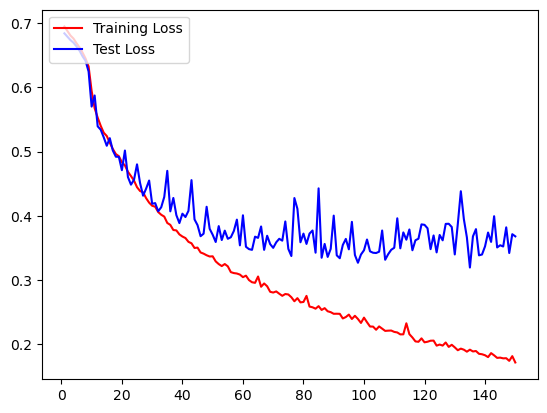

Epoch: 150 Train_Loss: 0.17630932627680201 Train_Accuracy: 0.934625
Epoch: 150 Test_Loss: 0.36980140246922455 Test_Accuracy: 0.8781


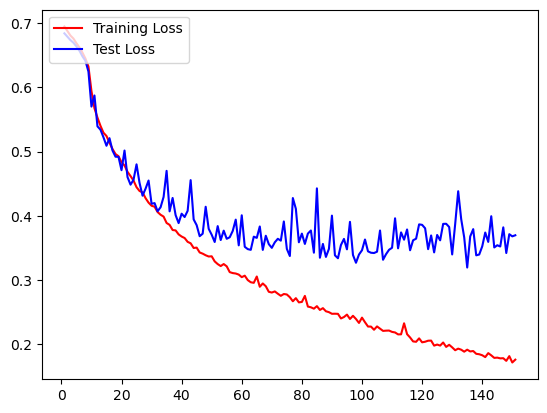

Epoch: 151 Train_Loss: 0.16610509971269785 Train_Accuracy: 0.93965
Epoch: 151 Test_Loss: 0.36955188969268077 Test_Accuracy: 0.8801


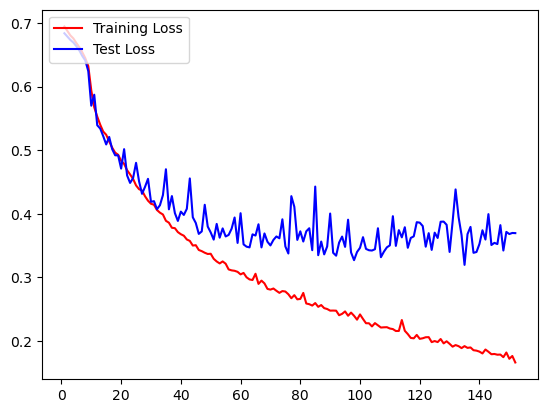

Epoch: 152 Train_Loss: 0.17097596224314107 Train_Accuracy: 0.93735
Epoch: 152 Test_Loss: 0.3672859672504135 Test_Accuracy: 0.8807


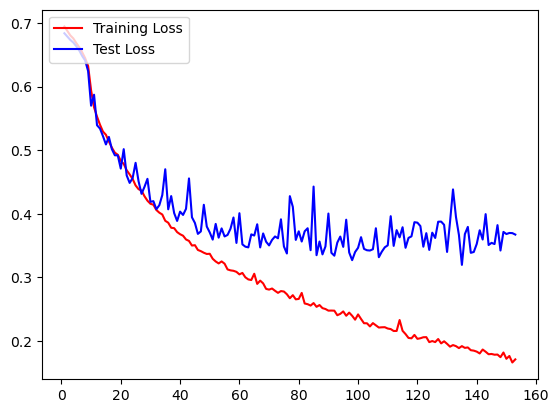

Epoch: 153 Train_Loss: 0.1621249597222089 Train_Accuracy: 0.942275
Epoch: 153 Test_Loss: 0.36076334571536584 Test_Accuracy: 0.8813


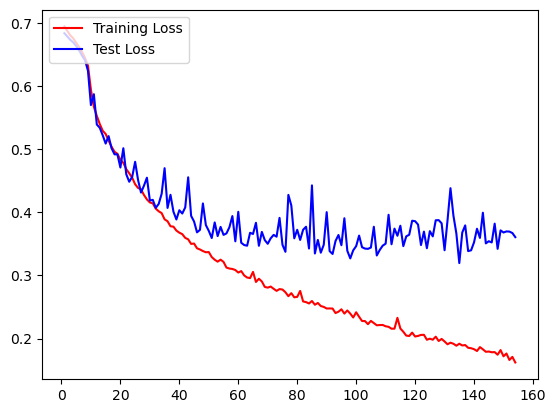

Epoch: 154 Train_Loss: 0.16929713821115966 Train_Accuracy: 0.938025
Epoch: 154 Test_Loss: 0.3531838225412972 Test_Accuracy: 0.8749


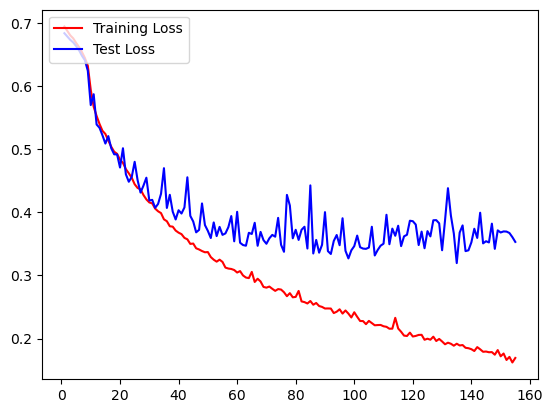

Epoch: 155 Train_Loss: 0.16861903717437873 Train_Accuracy: 0.9374
Epoch: 155 Test_Loss: 0.3923186852207667 Test_Accuracy: 0.8768


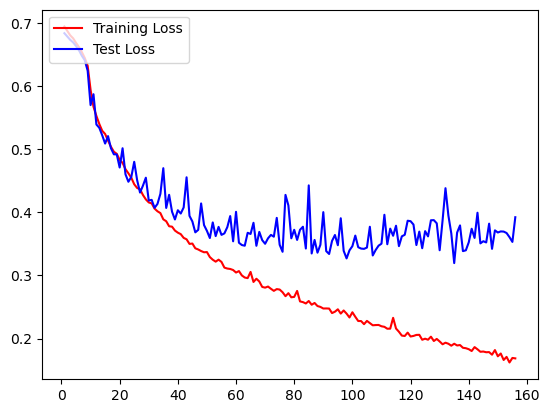

Epoch: 156 Train_Loss: 0.16318098860331617 Train_Accuracy: 0.94
Epoch: 156 Test_Loss: 0.3667021622008915 Test_Accuracy: 0.8801


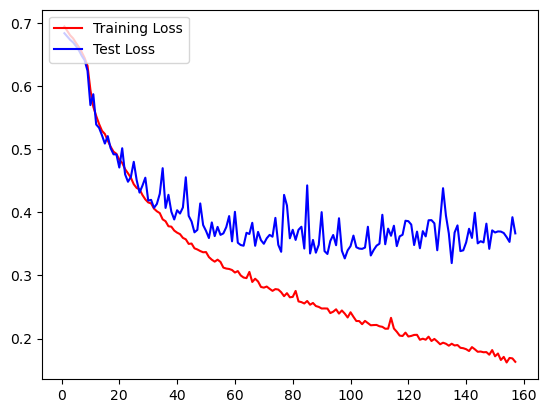

Epoch: 157 Train_Loss: 0.16458482474993213 Train_Accuracy: 0.940225
Epoch: 157 Test_Loss: 0.3550388777180563 Test_Accuracy: 0.8778


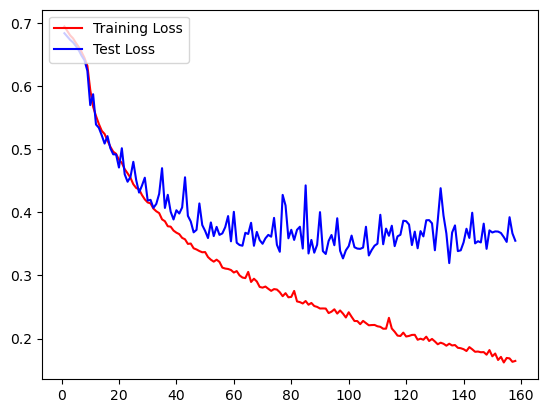

Epoch: 158 Train_Loss: 0.15965613369315196 Train_Accuracy: 0.9424
Epoch: 158 Test_Loss: 0.3843741009506998 Test_Accuracy: 0.8731


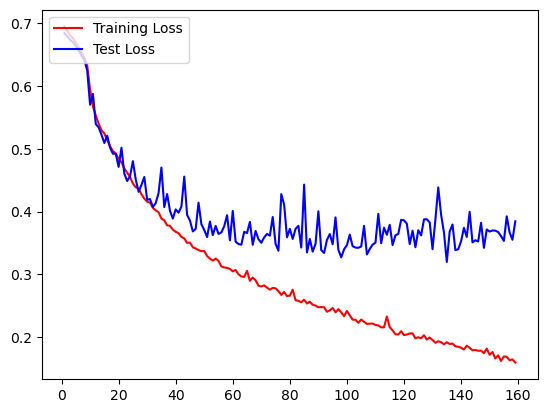

Epoch: 159 Train_Loss: 0.15835386177840324 Train_Accuracy: 0.942475
Epoch: 159 Test_Loss: 0.35734113051167016 Test_Accuracy: 0.8816


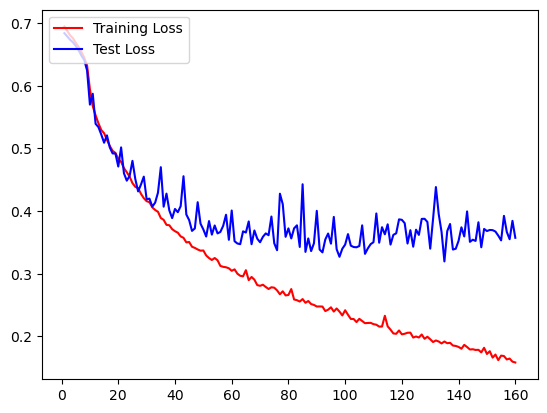

Epoch: 160 Train_Loss: 0.16088440675086108 Train_Accuracy: 0.942625
Epoch: 160 Test_Loss: 0.3763166664144661 Test_Accuracy: 0.8782


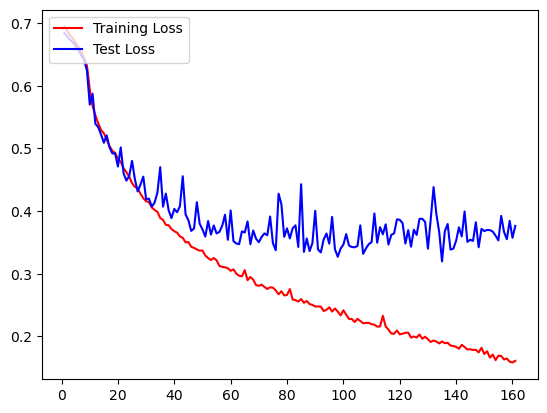

Epoch: 161 Train_Loss: 0.1691573148670669 Train_Accuracy: 0.93785
Epoch: 161 Test_Loss: 0.3573095138314404 Test_Accuracy: 0.8827


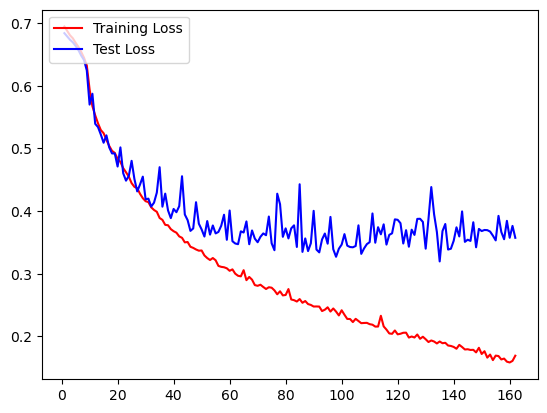

Epoch: 162 Train_Loss: 0.16215059265922815 Train_Accuracy: 0.94075
Epoch: 162 Test_Loss: 0.3909569716529001 Test_Accuracy: 0.8775


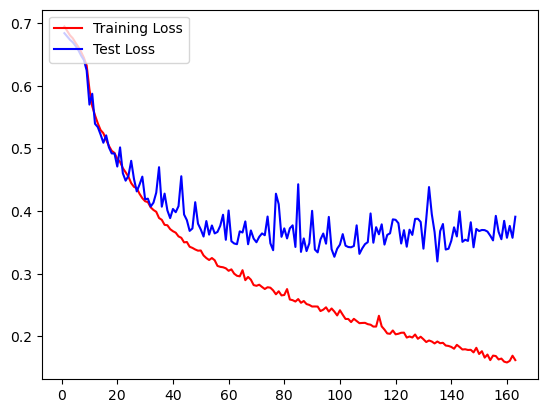

Epoch: 163 Train_Loss: 0.16551386013912697 Train_Accuracy: 0.939975
Epoch: 163 Test_Loss: 0.40941640998743756 Test_Accuracy: 0.864


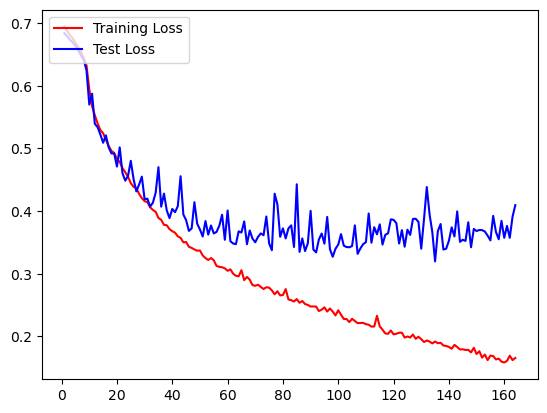

Epoch: 164 Train_Loss: 0.15369626473837766 Train_Accuracy: 0.94485
Epoch: 164 Test_Loss: 0.3784455392934099 Test_Accuracy: 0.8813


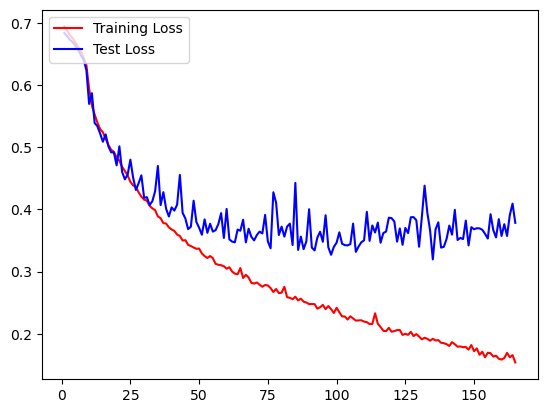

Epoch: 165 Train_Loss: 0.1484668223550335 Train_Accuracy: 0.94755
Epoch: 165 Test_Loss: 0.37608644083330905 Test_Accuracy: 0.8766


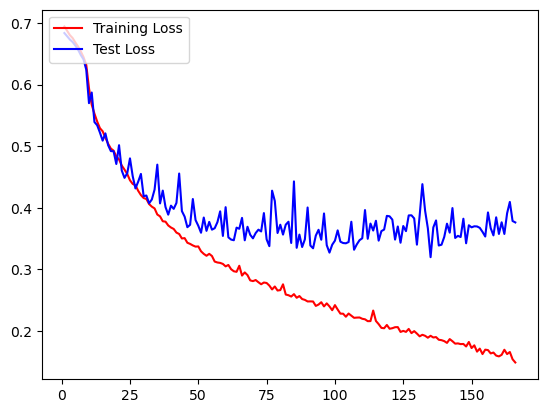

KeyboardInterrupt: 

In [15]:
from IPython.display import clear_output
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
weights = []
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights))
model = TextClassificationModel(pretrained_embeddings, 1, hidden_size=128)
gpus = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if gpus > 1:
    print("Let's use", gpus, "GPUs!")

loss_fn.to(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.0001)

epochs = 250

training_losses = [ None for i in range(epochs)]
test_losses = [ None for i in range(epochs)]
epoch_count = [i for i in range(1, epochs+1)]
recalls = [ None for i in range(epochs)]
precisions = [ None for i in range(epochs)]
accuracys = [ None for i in range(epochs)]
for e in range(epochs):
    model.train()
    epoch_loss = 0

    losses = []
    train_predictions_store = []
    train_labels_store = []
    for batch_id, batch in enumerate(train_dataloader):

        ids = batch['indices'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(ids)
        outputs = torch.reshape(outputs, (-1,))
        probs = torch.sigmoid(outputs)
        preds = torch.where(outputs > 0.5, 1, 0)
        loss = loss_fn(outputs, labels)

        labels = labels.to(torch.device("cpu")).numpy()
        preds = preds.to(torch.device("cpu")).numpy()
        for i in range(len(preds)):
            train_predictions_store.append(preds[i])
            train_labels_store.append(labels[i])

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    epoch_loss = np.mean(losses)

    training_losses[e] = epoch_loss
    train_accuracy = accuracy_score(train_labels_store, train_predictions_store)

    #  rp = classification_report(train_labels_store, train_predictions_store, target_names=['0','1'])
    #  print(rp)



    torch.save(model.state_dict(), 'Models/BiLSTM_model_epoch_{}.pt'.format(e))

    # Evaluate on test set
    with torch.no_grad():
        model.eval()
        test_loss = []
        test_correct_predictions = 0
        test_predictions_store = []
        test_labels_store = []

        for batch_id, batch in enumerate(test_dataloader):
            ids = batch['indices'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids)
            outputs = torch.reshape(outputs, (-1,))

            probs = torch.sigmoid(outputs)
            preds = torch.where(outputs > 0.5, 1, 0)
            loss = loss_fn(outputs, labels)

            test_correct_predictions += torch.sum(preds == labels)
            test_loss.append(loss.item())

            labels = labels.to(torch.device("cpu")).numpy()
            preds = preds.to(torch.device("cpu")).numpy()
            for i in range(len(preds)):
                test_predictions_store.append(preds[i])
                test_labels_store.append(labels[i])

        test_loss = np.mean(test_loss)
        test_accuracy = accuracy_score(test_labels_store, test_predictions_store)
        test_losses[e] = test_loss

        #rp = classification_report(test_labels_store, test_predictions_store, target_names=['0','1'])
        #print(rp)
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {}'.format(e, test_loss, test_accuracy))

        plt.plot(epoch_count, training_losses, 'r', label='Training Loss')
        plt.plot(epoch_count, test_losses, 'b', label='Test Loss')
        plt.legend(loc="upper left")

        plt.show()